# Project Name 

**Project Type -** EDA

**Contribution -** Individual

**Rakshit Pandey**

## Project Summary

**Overview:**

This project explores Airbnb listings in New York City to uncover patterns, trends, and insights that can enhance customer experience, optimize operational efficiency, and drive strategic business decisions. The dataset includes 48,895 records across 16 columns, offering a mix of categorical and numerical features related to Airbnb listings in NYC.

**Business Context:**

Airbnb, founded in 2008, has revolutionized travel by offering guests unique and personalized accommodations through its platform. Data analysis of Airbnb listings is crucial for improving the platform's offerings, understanding customer behavior, optimizing pricing strategies, and guiding marketing initiatives. This dataset contains 48,895 listings with information on location, room type, pricing, reviews, and host details, providing valuable insights into New York City's Airbnb landscape.

**Data Overview:**

- The dataset consists of 48,895 listings and 16 columns, including:

  - `id`, `name`, `host_id`, `host_name`, `neighbourhood_group`, `room_type`, `price`, `minimum_nights`, `number_of_reviews`, and others.

  - **Missing Values**: 20,141 missing values (2.57% of the dataset), primarily in `last_review` and `reviews_per_month`.

  - **Data Types**: Mix of `int64`, `float64`, and `object`.

**Key Insights & Findings:**

1. **Listing Distribution by Neighborhood**:

    - Listings are highly concentrated in Brooklyn (18,272 listings) and Manhattan (17,784 listings), representing over 70% of the total dataset.

   - Other neighborhoods like Queens (4,695) and the Bronx (970) have fewer listings.

3. **Room Type Distribution**:

   - **Entire homes/apartments** dominate in Manhattan (10,400 listings) and Brooklyn (9,017 listings).

   - **Private rooms** are most common in Brooklyn (9,024) and Manhattan (7,028).

   - Staten Island has the fewest listings, with a significant portion being **private rooms**.

5. **Average Price by Room Type & Neighborhood**:

   - **Entire homes/apartments** are the most expensive across all neighborhoods, with Manhattan listings averaging $189.38, significantly higher than other areas.

   - **Private rooms** are more affordable, averaging around **\$90** in Manhattan and **\$65** in Brooklyn.

   - **Shared rooms** tend to be the least expensive, especially in the Bronx and Queens.

7. **Average Reviews per Listing**:

   - **Staten Island** has the highest average number of reviews per listing (2.6), suggesting a more engaged audience.

   - **Manhattan** and **Brooklyn** show lower average reviews per listing (1.9–2.3), which may indicate more listings with fewer reviews.


9. **Host Performance**:

   - Top hosts, such as **Marcelo Y Lucio** and **The Broome Hotel**, manage up to 4 listings each.

   - Some hosts have accumulated impressive total reviews, with **Jason** receiving the highest at 21,579 reviews.

11. **Room Type Popularity**:
   
   - **Entire homes/apartments** are the most popular, with 21,853 listings, followed by **private rooms** (19,424 listings).
   
   - **Shared rooms** represent a small fraction of the dataset (754 listings).

11. **Outliers & Data Transformation**:
   
   - Outliers were identified and separated for further analysis, ensuring data integrity.
   
   - Log and square root transformations were applied to highly skewed data, such as `price` and `minimum_nights`, to stabilize variance and improve model performance.
   
   - To make visualizations more interpretable, the transformed data was reverted back to its original scale using `np.expm1`.

**Challenges Addressed:**

- Handling missing data: Imputed missing values where necessary to ensure a complete analysis.

- Dealing with skewed data: Applied appropriate transformations to normalize highly skewed variables like price.

- Outlier analysis: Isolated outliers to avoid skewing analysis results and preserve data integrity.

**Conclusion:**

This analysis provides a comprehensive understanding of Airbnb's NYC listings, offering valuable insights into pricing trends, neighborhood distributions, room types, and host performance. The findings can help Airbnb optimize operations, adjust pricing strategies, and enhance the customer experience on the platform. By leveraging data-driven insights, Airbnb can make informed decisions that align with user preferences and market demand.


## Github Link

**Provide your Github Link here.**

https://github.com/pandey-rakshit/Airbnb_nyc_analysis/

## Problem Statement

**Write Problem Statement Here.**

We aim to analyze Airbnb's NYC listings to uncover patterns and insights that can enhance customer experience, optimize operational efficiency, and inform strategic business decisions.

## Business Context

**Write Business Context Here**


Since 2008, guests and hosts have used Airbnb to expand on travelling possibilities and present a more unique, personalised way of experiencing the world. Today, Airbnb became one of a kind service that is used and recognized by the whole world. Data analysis on millions of listings provided through Airbnb is a crucial factor for the company. These millions of listings generate a lot of data - data that can be analysed and used for security, business decisions, understanding of customers' and providers' (hosts) behaviour and performance on the platform, guiding marketing initiatives, implementation of innovative additional services and much more. This dataset has around 49,000 observations in it with 16 columns and it is a mix of categorical and numeric values. Explore and analyse the data to discover key understandings.

### Define Your Business Objective ?

**Answer Here**

To analyze Airbnb listings in New York City to uncover patterns in pricing, room types, neighborhood distribution, and host performance. The insights gained will inform strategic decisions for optimizing pricing strategies, enhancing customer experience, improving operational efficiency, and identifying growth opportunities within the NYC market. This analysis aims to help Airbnb stay competitive by offering data-driven recommendations to support marketing, customer engagement, and service innovation.

## Dataset Description

**Dataset** :  https://raw.githubusercontent.com/pandey-rakshit/data-library/main/Airbnb/Airbnb.csv

**Data overview** :

|Field| Description|
|:--:|:--:|
|id| Unique ID|
|name | Name of the listing|
|host_id| unique host_id|
|host_name| Name of the Host|
|neighbourhood_group| location|
|neighborhood|area|
|latitude| Latitude range|
|longitude| Longitude range|
|room_type| type of listing|
|price| price of listing|
|minimum_nights| Minimum nights to be paid for|
|number_of reviews| number of reviews|
|last_review| Content of the last review|
|reeviews_per_month|Number of checks per month|
|calculated_host_listing_count|Total Count|
|availability_365| Availability around the year|



## Let's Begin !

### Project Setup -- constants 

In [1]:
data_url = 'https://raw.githubusercontent.com/pandey-rakshit/data-library/main/Airbnb/Airbnb.csv' # (support raw files only) - extension - {csv, xlsx, json, parquet}
skew_threshold = 0.5
outlier_threshold = 1.5

In [2]:
column_names = {
    'price': 'Price',
    'minimum_nights': 'Minimum Nights',
    'number_of_reviews': 'Number of Reviews',
    'reviews_per_month': 'Reviews per Month',
    'calculated_host_listings_count': 'Number of Listings per Host',
    'availability_365': 'Availability (Days per Year)',
    'latitude': 'Latitude',
    'longitude': 'Longitude',
}


### Prerequisite

In [3]:
# Library Installation

!pip install scipy scikit-learn pandas numpy matplotlib seaborn wordcloud --quiet

### Imports

In [4]:
# Importing necessary libraries

import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations, including mathematical functions like mean, median, sqrt, etc.

import matplotlib.pyplot as plt  # For creating a wide range of visualizations, such as bar plots, histograms, scatter plots, etc.
import seaborn as sns  # For advanced statistical visualizations, including pairplots, violin plots, and heatmaps

from scipy import stats  # For statistical functions like boxcox transformation, normality tests, correlation calculations, and more
from sklearn.preprocessing import PowerTransformer  # For data scaling and transformations, e.g., Yeo-Johnson for skewed data

from wordcloud import WordCloud

from pathlib import Path


In [5]:
# Optional: Setting styles for plots
sns.set_style("darkgrid")

### Utilities

#### Visualizatioin - Utitlity

In [6]:
# chart visualzation function

plot_functions = {
    'scatter': sns.scatterplot,
    'line': sns.lineplot,
    'bar': sns.barplot,
    'box': sns.boxplot,
    'hist': sns.histplot,
    'pie': plt.pie,
    'count': sns.countplot,
    'heatmap': sns.heatmap
}


def visualize_chart(chart_objs, nrows=1, ncols=1, **kwargs):
    """
    Create a custom visualization chart with optional subplots.

    Parameters:
    - chart_objs (list): List of dictionaries, where each dictionary contains
                          chart-specific information like 'plot_function', 'titles', etc.
    - nrows (int): Number of rows for the subplot grid. Default is 1.
    - ncols (int): Number of columns for the subplot grid. Default is 1.
    - **kwargs: Additional common keyword arguments passed to the plotting function.

    Returns:
    - fig (matplotlib.figure.Figure): The created figure object.
    """


    width = 18 if ncols == 1 else ncols * 5.43
    height = 6 if nrows == 1 else nrows * 4
    
    plt.figure(figsize=(width, height))
    
    # print(axes)
    
    # Loop through chart_objs to plot the respective data
    for i, chart in enumerate(chart_objs, 1):

        plot_function = chart['plot_function']
        title = chart['title']
        xlabel = chart.get('xlabel', None)
        ylabel = chart.get('ylabel', None)
        x = chart['x']
        y = chart.get('y', None)
        chart_kwargs = chart.get('kwargs', {})

        
        plt.subplot(nrows, ncols, i)
        
        # Construct the plotting function arguments
        # Adjust the plot_args dynamically based on the plot function
        plot_args = {'data': x} if plot_function == plot_functions['heatmap'] else {'x': x}
       
        if y is not None:
            plot_args['y'] = y
        
        # Add any additional keyword arguments for this specific chart
        plot_args.update(chart_kwargs)
        
        # Call the plot function
        ax = plot_function(**plot_args)

        plt.title(title, fontsize=16, pad=20)

        if xlabel is not None:
            plt.xlabel(xlabel)

        if ylabel is not None:
            plt.ylabel(ylabel)


        if plot_function in [plot_functions['bar'], plot_functions['count']]:
            for i in ax.containers:
                ax.bar_label(i, fmt='%.2f')

    # Adjust layout for better readability
    plt.tight_layout()

    fig = plt.gcf()

    return fig


#### DataFrame - Utitlity

In [7]:
def get_file_extension_from_path(input_path):
    # Use Path on system path (e.g., relative or absolute)
    file_extension = Path(input_path).suffix.lstrip('.')
    return file_extension.lower()

In [8]:

def create_dataframe(data_url: str) -> pd.DataFrame:
    """
    Reads raw data from a URL or file path and creates a DataFrame.

    Args:
        data_url (str): URL or file path of the raw data (e.g., GitHub raw file).
        data_type (str): The type of the data ('csv', 'xlsx', 'json', 'parquet').

    Returns:
        pd.DataFrame: A pandas DataFrame containing the data.
        
    """
    # Map data types to pandas functions
    read_functions = {
        "csv": pd.read_csv,
        "xlsx": pd.read_excel,
        "json": pd.read_json,
        "parquet": pd.read_parquet,
    }

    data_type = get_file_extension_from_path(data_url)
    
    if data_type not in read_functions:
        raise ValueError(f"Unsupported data type: {data_type}")

    try:
        # Use the appropriate pandas function to read the data
        df = read_functions[data_type](data_url)
        return df

    except Exception as e:
        raise RuntimeError(f"Failed to create DataFrame: {e}")


In [9]:
def analyze_dataset(df, exclude_columns=None):
    """
    Performs analysis on the dataset and stores the results.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        exclude_columns (list): List of columns to exclude from summary statistics (optional).
    
    Returns:
        dict: A dictionary with the results of the analysis.
    """
    results = {}

    # General dataset info
    results['rows'], results['columns'] = df.shape

    # Missing values
    missing_count = df.isnull().sum()
    missing_details = missing_count[missing_count > 0].to_dict()
    total_missing = missing_count.sum()
    results['missing_values'] = {
        'total': total_missing,
        'percentage': (total_missing / (results['rows'] * results['columns'])) * 100,
        'details': missing_details
    }

    # Duplicate rows
    results['duplicate_rows'] = df.duplicated().sum()

    # Data types
    results['data_types'] = df.dtypes.reset_index()
    results['data_types'].columns = ['Column', 'DataType']

    # Exclude columns from analysis (if provided)
    numeric_df = df.select_dtypes(include=['number'])
    if exclude_columns:
        numeric_df = numeric_df.drop(columns=exclude_columns, errors='ignore')

    # Summary statistics
    results['statistics'] = numeric_df.describe().T
    results['statistics'] = results['statistics'].round(2)  # Format statistics to 2 decimal points

    # Additional observations for each column
    observations = {}
    for col in results['statistics'].index:
        stats = results['statistics'].loc[col]
        mean = stats['mean']
        median = stats['50%']
        if mean < median:
            observations[col] = "Data is left-skewed (mean < median)."
        elif mean > median:
            observations[col] = "Data is right-skewed (mean > median)."
        else:
            observations[col] = "Data is symmetric (mean ≈ median)."

    results['observations'] = observations

    return results


#### Correlation Utility

In [10]:
def visualize_correlation_matrix(df, columns=None, correlation_matrix=None):
    """
    Visualize the correlation matrix of numeric columns using a heatmap.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze and visualize.
        columns (list, optional): List of columns to calculate correlation matrix. 
                                  If None, the entire DataFrame will be used.
        correlation_matrix (pd.DataFrame, optional): Precomputed correlation matrix to visualize. 
                                                     If None, the correlation matrix will be computed from 'columns'.
    
    Returns:
        fig: The generated figure object.
    """
    # Compute the correlation matrix based on the inputs (columns or precomputed correlation_matrix)
    if correlation_matrix is None:
        # If correlation_matrix is not provided, compute it from the given columns or all numeric columns
        numeric_columns = columns if columns else df.select_dtypes(include=['number']).columns
        correlation_matrix = df[numeric_columns].corr(numeric_only=True)
    
    # Create chart_objs with the heatmap visualization for the correlation matrix
    chart_objs = [{
        'plot_function': plot_functions['heatmap'],
        'title': 'Relationship between Variables: Correlation Matrix',
        'xlabel': 'Features',
        'ylabel': 'Features',
        'x': correlation_matrix,  # Using the correlation matrix for visualization
        'kwargs': {
            'annot': True,  # Show correlation coefficients in the heatmap
            'cmap': 'viridis',  # Color map for the heatmap
            'fmt': '.2f',  # Format for the correlation values
            'linewidths': 0.7,  # Line thickness between cells
            'vmin': -1,
            'vmax': 1
            # 'cbar_kws': {'shrink': 0.75}  # Color bar size adjustment
        }
    }]
    
    # Visualize the correlation matrix using the visualize_chart function
    return visualize_chart(chart_objs, nrows=1, ncols=1)


In [11]:
def analyze_correlation_matrix(df, columns=None, threshold=None):
    """
    Analyze the correlation matrix of a DataFrame and optionally filter correlations by a threshold.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        columns (list, optional): List of columns to include in the correlation analysis. If None, all numeric columns are used.
        threshold (float, optional): Correlation threshold to filter significant correlations. If None, no filtering is applied.

    Returns:
        dict: A dictionary containing the full correlation matrix and the filtered correlation matrix.
    """
    
    # Use only the specified columns or default to all numeric columns
    if columns is not None:
        # Check if the provided columns are numeric
        non_numeric_columns = [col for col in columns if df[col].dtype not in ['int64', 'float64']]
        
        if non_numeric_columns:
            print(f"Warning: The following non-numeric columns were excluded from skewness analysis: {', '.join(non_numeric_columns)}")
            # Remove non-numeric columns from the columns list
            columns = [col for col in columns if col not in non_numeric_columns]
        
    else:
        columns = df.select_dtypes(include='number').columns.tolist()
    
    if not columns:
        raise ValueError("No numeric columns available for correlation analysis.")

    # Compute the correlation matrix for the selected columns
    filtered_df = df[columns]
    correlation_matrix = filtered_df.corr()

    # Filter the correlation matrix based on the threshold
    if threshold is not None:
        filtered_matrix = correlation_matrix[abs(correlation_matrix) >= threshold].fillna(0)
    else:
        filtered_matrix = correlation_matrix  # No filtering applied if threshold is None


    visualize_correlation_matrix(df, correlation_matrix=correlation_matrix)
    plt.xticks(rotation=0)
    plt.show()
    
    # Return both the full and filtered correlation matrices
    return {
        "correlation_matrix": correlation_matrix,
        "filtered_correlation_matrix": filtered_matrix
    }


#### Skewness Utitlity

In [12]:
def calculate_skewness(df, columns=None):
    """
    Calculate skewness for specific columns or all numeric columns in the DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        columns (list): A list of column names for which skewness needs to be calculated. 
                          If None, skewness will be calculated for all numeric columns.
    
    Returns:
        dict: A dictionary with column names as keys and skewness values as values.
    """
    if columns is None:
        # If no column names are provided, calculate skewness for all numeric columns
        numeric_columns = df.select_dtypes(include=['number']).columns
    else:
        # Check if the provided columns are numeric
        non_numeric_columns = [col for col in columns if df[col].dtype not in ['int64', 'float64']]
        
        if non_numeric_columns:
            print(f"Warning: The following non-numeric columns were excluded from skewness analysis: {', '.join(non_numeric_columns)}")
            # Remove non-numeric columns from the columns list
            columns = [col for col in columns if col not in non_numeric_columns]

    # Calculate skewness for the selected columns
    skewness_dict = {col: df[col].skew() for col in numeric_columns}
    return skewness_dict


In [13]:
def visualize_skewness_with_chart(df, numeric_columns):
    """
    Visualize skewness of all numeric columns using histograms with KDE.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze and visualize.
    
    Returns:
        fig: The generated figure object.
    """
    # Identify numeric columns
    # numeric_columns = df.select_dtypes(include=['number']).columns
    
    # Calculate skewness for each numeric column
    skewness = df[numeric_columns].skew().round(2)

    # print(skewness)
    
    # Create chart_objs with customized titles and other options for each column
    chart_objs = []
    for col in numeric_columns:
        # print(col, skewness[col])
        chart_objs.append({
            'plot_function':plot_functions['hist'] ,
            'title': f'Skewness of {col}: {skewness[col]}',  # Title for each individual column
            'xlabel': col,
            'ylabel': 'Frequency',
            'x': df[col],
            'kwargs': {'kde': True, 'color': 'purple', 'element': 'poly'}
        })


    # print(chart_objs)
    
    # Visualize skewness using the visualize_chart function
    return visualize_chart(chart_objs, nrows=(len(numeric_columns) // 3 + 1), ncols=3)

# # Example: Visualize the skewness of all numeric columns in the DataFrame
# fig = visualize_skewness_with_chart(df)
# plt.show()




In [14]:
def analyze_skewness(df, columns=None):
    """
    Analyze the skewness of numeric columns in the dataset and generate a summary of skewness categories.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        columns (list, optional): List of columns to include in the skewness analysis. 
                                   If None, all numeric columns will be considered.
    
    Returns:
        dict: A dictionary containing the skewness analysis result categorized by 'high', 'moderate', and 'low'.
        plt.Figure: A Matplotlib figure object displaying histograms of the skewness.
    """
    # Determine the columns to analyze (use all numeric columns if no specific columns are provided)
    if columns is None:
        columns = df.select_dtypes(include="number").columns.tolist()
    
    # Check if the provided columns are numeric
    non_numeric_columns = [col for col in columns if df[col].dtype not in ['int64', 'float64']]
    
    if non_numeric_columns:
        print(f"Warning: The following non-numeric columns were excluded from skewness analysis: {', '.join(non_numeric_columns)}")
        # Remove non-numeric columns from the columns list
        columns = [col for col in columns if col not in non_numeric_columns]

    # If there are no numeric columns to analyze, raise an error
    if not columns:
        raise ValueError("No numeric columns available in the dataset for skewness analysis.")
    
    # Calculate skewness for each numeric column
    skewness_values = df[columns].apply(lambda x: x.skew()).to_dict()

    # Categorize columns based on skewness values
    high_skew = [col for col, skew in skewness_values.items() if abs(skew) > 1]
    moderate_skew = [col for col, skew in skewness_values.items() if 0.5 < abs(skew) <= 1]
    low_skew = [col for col, skew in skewness_values.items() if abs(skew) <= 0.5]

    # Prepare the result object
    skewness_result = {
        "high_skew": high_skew,
        "moderate_skew": moderate_skew,
        "low_skew": low_skew,
        "skewness_values": skewness_values  # For detailed skewness values of each column
    }

    # print(skewness_result)
    # Generate and visualize skewness distribution for the specified columns
    visualize_skewness_with_chart(df, columns)

    return skewness_result


#### DataFrame - Manipulation - Utility

##### Dtype - conversion _(changing column dtype)_

In [15]:
def transform_columns(df, columns, new_type):
    """
    Converts specified columns to a new data type.
    
    Args:
        df (pd.DataFrame): The DataFrame to transform.
        columns (list): List of column names to convert.
        new_type (type): The new data type (e.g., int, float, str).
    
    Returns:
        pd.DataFrame: DataFrame with updated column types.
    """
    for column in columns:
        try:
            df[column] = df[column].astype(new_type)
            print(f"Column '{column}' successfully converted to {new_type}.")
        except Exception as e:
            print(f"Error converting column '{column}' to {new_type}: {e}")
    return df

##### Column Imputation -- _(Handling missing values)_

In [16]:
def impute_column(col, method):
    """
    Impute missing values in a column based on the specified method.
    
    Args:
        col (pd.Series): The column to impute.
        method (str): The imputation method ('median', 'mean', or 'mode').
        
    Returns:
        pd.Series: The column with imputed values.
    """
    if method == 'median':
        return col.fillna(col.median())
    elif method == 'mean':
        return col.fillna(col.mean())
    elif method == 'mode':
        return col.fillna(col.mode()[0])
    else:
        raise ValueError(f"Unsupported imputation method: {method}")



In [17]:
def impute_missing(df, exclude_columns=None):
    """
    Impute missing values for numeric, categorical, datetime, and boolean columns.
    
    Args:
        df (pd.DataFrame): The dataset to process.
        exclude_columns (list): Columns to exclude from the imputation process.
        
        
    Returns:
        pd.DataFrame: DataFrame with imputed missing values.
    """
    
    # If no exclude_columns are provided, initialize as an empty list
    exclude_columns = exclude_columns or []
    
    for col in df.columns:
        if col not in exclude_columns and df[col].isnull().any():  # Check if the column has missing values
            dtype = df[col].dtype

            # Handle numeric columns
            if dtype in ['int64', 'float64']:
                skew = df[col].skew()  # Calculate skewness for numeric columns
                if abs(skew) > 0.5:
                    df[col] = impute_column(df[col], 'median')
                else:
                    df[col] = impute_column(df[col], 'mean')
            # Handle categorical, boolean, and datetime columns
            elif dtype in ['object', 'category', 'bool', 'datetime64[ns]']:
                df[col] = impute_column(df[col], 'mode')

    return df


#### Handling Outliers

In [18]:
def remove_outliers(df, col, lower, upper):
    """Remove rows with outliers for the given column."""
    return df[(df[col] >= lower) & (df[col] <= upper)]

In [19]:
def flag_outliers(df, col, lower, upper):
    """Flag outliers for the given column by adding a new column."""
    df[f"{col}_outlier"] = (df[col] < lower) | (df[col] > upper)
    return df

In [20]:
def transform_outliers(df, col, lower, upper):
    """Clip outliers for the given column to the bounds."""
    df[col] = df[col].clip(lower=lower, upper=upper)
    return df


In [21]:
def handle_outliers_in_data(df, columns=None, method='remove', threshold=1.5):
    """
    Detect and handle outliers in the DataFrame using the IQR method without using if-else.
    
    Args:
        df (pd.DataFrame): The DataFrame to check for outliers.
        columns (list, optional): List of columns to check for outliers. If None, all numeric columns are used.
        method (str): Method to handle outliers - 'remove', 'flag', or 'transform'.
        threshold (float): The IQR multiplier for detecting outliers.
    
    Returns:
        pd.DataFrame: DataFrame with outliers handled (removed, flagged, or transformed).
        pd.DataFrame: DataFrame containing only the outliers.
    """
    # Select numeric columns if no specific columns are provided
    columns = columns or df.select_dtypes(include=["number"]).columns.tolist()

    # DataFrames for results
    df_result = df.copy()
    outliers_list = []

    # Map methods to functions
    method_actions = {
        'remove': remove_outliers,
        'flag': flag_outliers,
        'transform': transform_outliers,
    }

    # Raise error for invalid method
    if method not in method_actions:
        raise ValueError(f"Invalid method '{method}'. Choose from 'remove', 'flag', or 'transform'.")

    # Loop through each column and handle outliers
    for col in columns:
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found in the DataFrame. Skipping...")
            continue

        # Calculate IQR bounds
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Identify outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_list.append(outliers)

        print(f"Outliers detected for '{col}': {len(outliers)}")

        # Call the appropriate method
        df_result = method_actions[method](df_result, col, lower_bound, upper_bound)

    # Concatenate all outliers into a single DataFrame
    df_outliers = pd.concat(outliers_list).drop_duplicates()

    return df_result, df_outliers

#### Data Transformation - _(log, sqrt)_

In [22]:
def apply_transformation(df, column, transformation_type):
    """
    Apply the specified transformation to a column in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the column to transform.
        column (str): The name of the column to transform.
        transformation_type (str): The type of transformation to apply. 
                                   Supported: 'log', 'sqrt', 'square', 'reciprocal'.

    Returns:
        pd.Series: Transformed column as a pandas Series.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")

    # Transformation mapping
    transformations = {
        'log': lambda x: np.log1p(x),
        'sqrt': lambda x: np.sqrt(x.clip(lower=0)),
        'square': lambda x: np.square(x),
        'reciprocal': lambda x: 1 / x.replace(0, np.nan)
    }

    # Get the transformation function
    transform_func = transformations.get(transformation_type)
    if not transform_func:
        raise ValueError(f"Unsupported transformation type: '{transformation_type}'.")

    # Apply the transformation
    return transform_func(df[column])


In [23]:
def best_transformation_with_outliers(df, skew_categories, handle_outliers=False):
    """
    Apply the best transformation based on skewness for each column already categorized into high, moderate, or low skew.
    Optionally, handle outliers by removing or transforming them.

    Args:
        df (pd.DataFrame): The DataFrame containing numeric columns.
        skew_categories (dict): Dictionary with keys 'high', 'moderate', 'low' mapping to lists of column names.
        handle_outliers (bool): Whether to handle outliers by removal after transformation.
        skew_threshold (float): The threshold for determining the degree of skewness for transformation.
        outlier_threshold (float): The threshold for detecting outliers based on IQR method.

    Returns:
        pd.DataFrame: DataFrame with transformations applied to columns and outliers handled (if applicable).
    """
    transformed_df = df.copy()  # Create a copy to apply transformations

    # Dictionary of transformations for each skew category
    transformations = {
        'high_skew': 'log',
        'moderate_skew': 'sqrt'
    }
    
    # 'low': 'boxcox'  # Optional, or we can skip transformation for low skew

    transformed_col = []
    # Apply transformations based on skew category
    for skew_category, transformation_type in transformations.items():
        columns = skew_categories.get(skew_category, [])
        for col in columns:
            print(f"Applying {transformation_type} transformation to {col} due to {skew_category} skewness.")
            transformed_df[col] = apply_transformation(transformed_df, col, transformation_type)
            transformed_col.append(col)

    
    # Handle outliers if required
    if handle_outliers:
        transformed_df = handle_outliers_in_data(transformed_df, transformed_col)
    
    return transformed_df

#### Summary Generation -- _(Factory class to register and use summary related functions)_

In [24]:
# Define the Factory Class for Summaries
class SummaryFactory:
    def __init__(self):
        self.steps = {}

    def register_step(self, step_name, step_function):
        """
        Registers a summary step to the factory.
        
        Args:
            step_name (str): The name of the step.
            step_function (function): The function to generate the summary for this step.
        """
        self.steps[step_name] = step_function

    def generate_summary(self, step_name, *args, **kwargs):
        """
        Generates the summary for the specified step.
        
        Args:
            step_name (str): The name of the step to execute.
            *args: Positional arguments for the step function.
            **kwargs: Keyword arguments for the step function.
        
        Returns:
            str: The generated summary.
        """
        if step_name not in self.steps:
            raise ValueError(f"Step '{step_name}' is not registered in the factory.")
        return self.steps[step_name](*args, **kwargs)


In [25]:

# Step 1: Overview Function
def overview_step(result):
    """
    Generates an overview summary from the dataset analysis results.
    
    Args:
        result (dict): The analysis results dictionary.
    
    Returns:
        str: Overview summary.
    """
    summary = []

    # General dataset information
    summary.append(f"The dataset contains {result['rows']} rows and {result['columns']} columns.\n")

    # Missing values
    missing_values = result['missing_values']
    summary.append(f"There are {missing_values['total']} missing values across {len(missing_values['details'])} columns.")
    summary.append(f"Missing values account for {missing_values['percentage']:.2f}% of the dataset.")
    if missing_values['details']:
        summary.append("Columns with missing values and their counts:")
        for col, count in missing_values['details'].items():
            summary.append(f"  - {col}: {count} missing values")
    summary.append("")  # Add a blank line for spacing

    # Duplicate rows
    duplicate_rows = result['duplicate_rows']
    if duplicate_rows > 0:
        summary.append(f"There are {duplicate_rows} duplicate rows in the dataset.")
    else:
        summary.append("There are no duplicate rows in the dataset.")
    summary.append("")  # Add a blank line for spacing

    # Data types
    summary.append("Data Types:\n")
    data_types = result['data_types']
    
    summary.append(data_types.to_string(index=False))

    # for _, row in data_types.iterrows():
    #     summary.append(f"  - {row['Column']}: {row['DataType']}")
    
    summary.append("")  # Add a blank line for spacing

    # Summary Statistics
    summary.append("Summary Statistics:\n")
    statistics = result['statistics']
    summary.append(statistics.to_string())  # Use pandas' `to_string` for a clean table-like output

    return "\n".join(summary)



In [26]:
# Step 2: Observations Function
def observations_step(result):
    """
    Generates observations based on numerical analysis.
    
    Args:
        result (dict): The analysis results dictionary.
    
    Returns:
        str: Observations summary.
    """
    summary = []

    # Observations from numerical columns
    summary.append("Observations based on the dataset:\n")
    observations = result.get('observations', {})
    
    for col, observation in observations.items():
        summary.append(f"  - {col}: {observation}")

    return "\n".join(summary)

In [27]:
def skewness_summary(skewness_object):
    """
    Generate a textual and tabular summary of skewness using the skewness object.

    Args:
        skewness_object (dict): A dictionary containing skewness analysis results.

    Returns:
        str: A formatted textual and tabular summary of the skewness analysis.
    """
    summary = []

    # Categorize and format the summary based on the skewness object
    if skewness_object.get("high_skew"):
        summary.append(f"- Highly skewed columns (suggesting log transformation): {', '.join(skewness_object['high_skew'])}")
    if skewness_object.get("moderate_skew"):
        summary.append(f"- Moderately skewed columns (suggesting square root transformation): {', '.join(skewness_object['moderate_skew'])}")
    if skewness_object.get("low_skew"):
        summary.append(f"- Columns with low skewness (no transformation needed): {', '.join(skewness_object['low_skew'])}")
    
    # Convert detailed skewness values into a table
    if skewness_object.get("skewness_values"):
        skewness_df = pd.DataFrame.from_dict(skewness_object["skewness_values"], orient="index", columns=["Skewness"])
        skewness_df.index.name = "Column"
        skewness_df.reset_index(inplace=True)
        summary.append("\nDetailed Skewness Values:\n")
        summary.append(skewness_df.to_string(index=False))

    return "\n".join(summary)


In [28]:
summary_factory = SummaryFactory()

# Register steps
summary_factory.register_step("overview", overview_step)
summary_factory.register_step("observations", observations_step)
summary_factory.register_step("skewness", skewness_summary)

# print(summary_factory.generate_summary("overview", result)) # to generate summary

### Custom Utility

In [29]:
# function to handle missing values in name column: using host_name = '{host_name} housing'

def handle_missing_name(row):
  if pd.isna(row['name']):
    row['name'] = row['host_name'] + ' Housing'
  return row

In [30]:
# function to handle missing values of host_name by 'host_{host_id}'

def handle_missing_host_name(row):
  if pd.isna(row['host_name']):
    host_id = row['host_id']
    row['host_name'] = f'Host_{host_id}'
  return row

In [31]:
# handling missing values in reviews_per_month

def handle_missing_reviews_per_month(row):
  if pd.isna(row['reviews_per_month']):
    row['reviews_per_month'] = 0
  return row

## Exploratory Data Analysis

In [32]:
# Creating dataframe

df = create_dataframe(data_url)

In [33]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [34]:
df.tail()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2
48894,36487245,Trendy duplex in the very heart of Hell's Kitchen,68119814,Christophe,Manhattan,Hell's Kitchen,40.76404,-73.98933,Private room,90,7,0,NaN,NaN,1,23


In [35]:
# excluding non-numeric and columns that are not needed in descriptive summary function like df.describe(), correlation and skewness etc

exclude_columns = {'id', 'host_id', 'latitude', 'longitude', 'name', 'host_name', 'neighbourhood_group', 'room_type', 'neighbourhood', 'last_review'}

In [36]:
result = analyze_dataset(df, exclude_columns) 

In [37]:
print(summary_factory.generate_summary("overview", result))
print("\n" + "="*80 + "\n")
print(summary_factory.generate_summary("observations", result))

The dataset contains 48895 rows and 16 columns.

There are 20141 missing values across 4 columns.
Missing values account for 2.57% of the dataset.
Columns with missing values and their counts:
  - name: 16 missing values
  - host_name: 21 missing values
  - last_review: 10052 missing values
  - reviews_per_month: 10052 missing values

There are no duplicate rows in the dataset.

Data Types:

                        Column DataType
                            id    int64
                          name   object
                       host_id    int64
                     host_name   object
           neighbourhood_group   object
                 neighbourhood   object
                      latitude  float64
                     longitude  float64
                     room_type   object
                         price    int64
                minimum_nights    int64
             number_of_reviews    int64
                   last_review   object
             reviews_per_month  float64
calcu

### Handling Missing Values

There are 20141 missing values across 4 columns.

Columns with missing values and their counts:
  - name: 16 missing values
  - host_name: 21 missing values
  - last_review: 10052 missing values
  - reviews_per_month: 10052 missing values

In [38]:
# Handling missing value - Name column

df[df['name'].isna()][['id','name', 'host_name', 'host_id']]

,id,name,host_name,host_id
2854,1615764,NaN,Peter,6676776
3703,2232600,NaN,Anna,11395220
5775,4209595,NaN,Jesse,20700823
5975,4370230,NaN,Michaël,22686810
6269,4581788,NaN,Lucie,21600904
6567,4756856,NaN,Carolina,1832442
6605,4774658,NaN,Josh,24625694
8841,6782407,NaN,Huei-Yin,31147528
11963,9325951,NaN,Jonathan,33377685
12824,9787590,NaN,Miguel,50448556


In [39]:
# Applying change listing name function to handle missing values in name column

df = df.apply(handle_missing_name, axis=1)

In [40]:
df = df.apply(handle_missing_host_name, axis=1)

In [41]:
# Checking reason behind missing values in last review and reviews per month column 

missing_last_review_and_review_per_month_df = df[df['last_review'].isna().eq(True) & df['reviews_per_month'].isna().eq(True)]

In [42]:
missing_last_review_and_review_per_month_df.shape

(10052, 16)

> Note:
>
> missing values in `last_review = reviews_per_month = 10052`

- All missing values in last review and reviews_per_month are common rows and equal to total missing values i.e. ***10052***

- We can proceed with any of the two appraches:
  - Removing missing values
  - imputing the missing values

* Before moving ahead lets check if we can impute the values to prevent data loss.

In [43]:
missing_last_review_and_review_per_month_df['number_of_reviews'].eq(0).sum()

10052

> Note:
>
> As number of reviews are 0. we can conclude that there are no reviews added since ever
and this is the reason for missing values in last review and reviews per month.

Hence we `impute the value 0` to `reviews_per_month` and either `no reviews` in object type or leave the `last review column` as `null` to prevent data loss


In [44]:
df = df.apply(handle_missing_reviews_per_month, axis=1)

In [45]:
df['last_review'] = df['last_review'].apply(pd.to_datetime)

In [46]:
df.dtypes

id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
dtype: object

### Correlation

In [47]:
filter_column = list(set(df.columns) - exclude_columns)

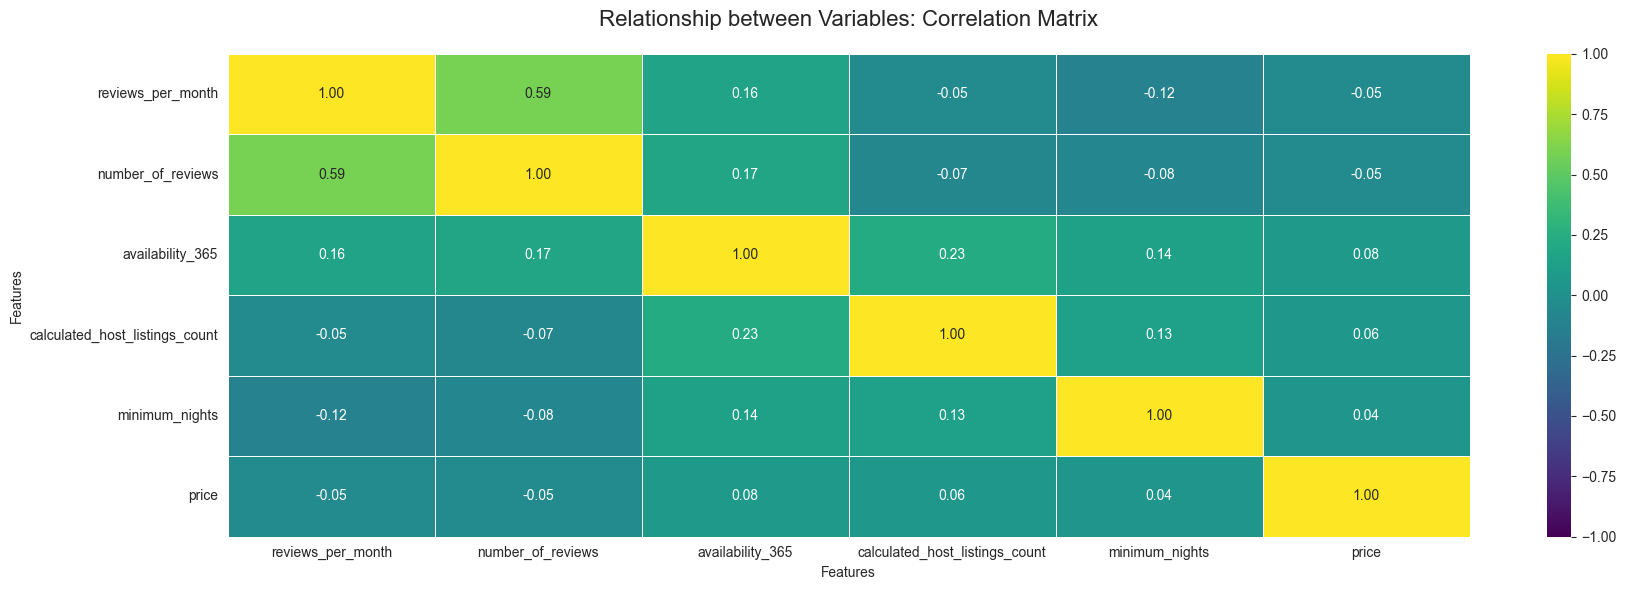

In [48]:
result = analyze_correlation_matrix(df, filter_column)

### Skewness

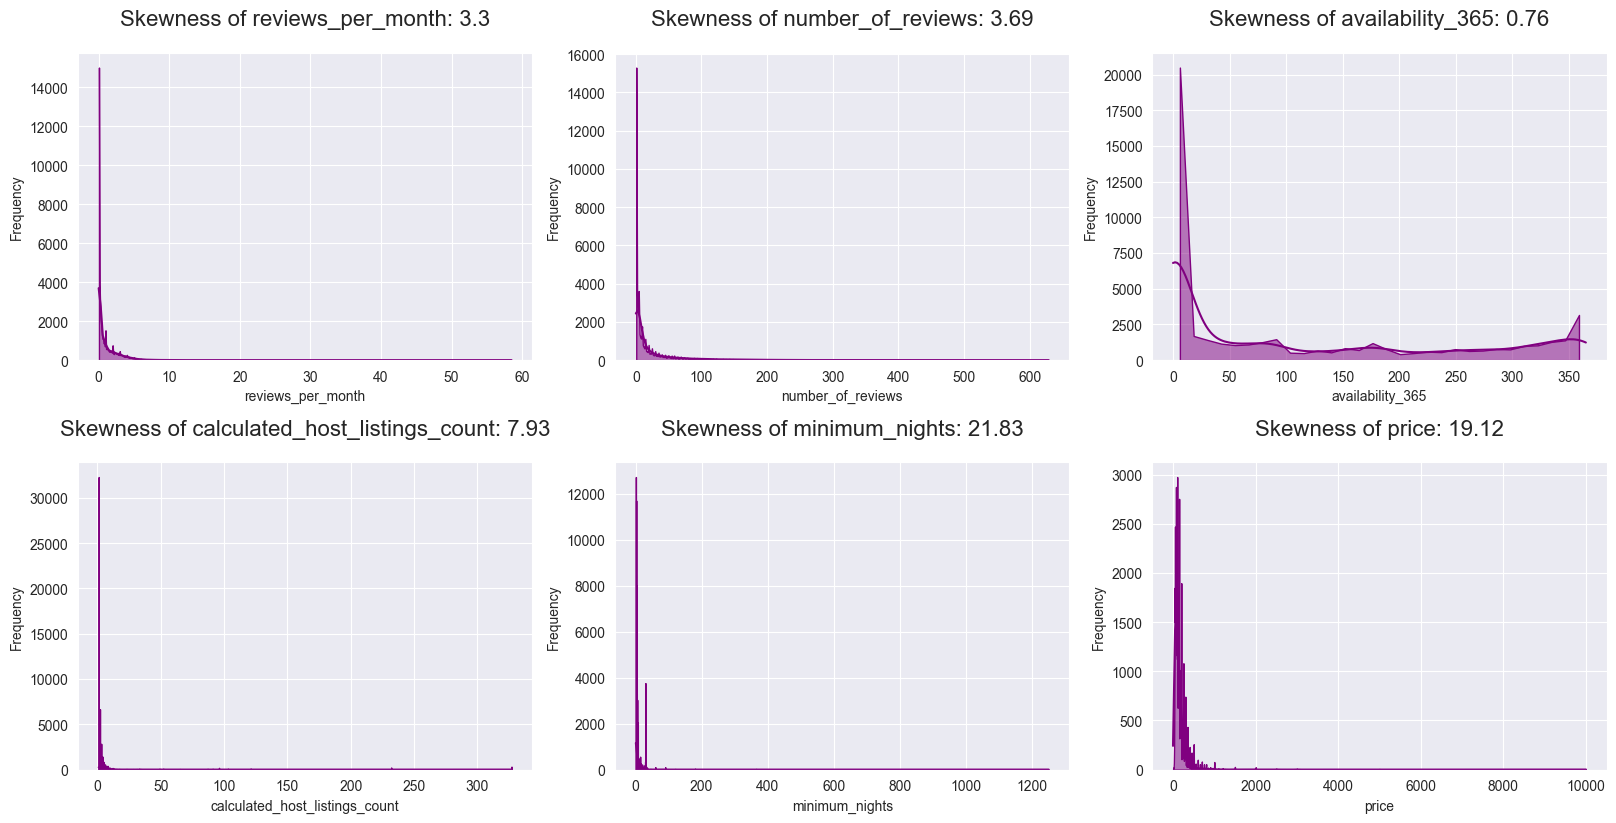

In [49]:
skewness = analyze_skewness(df, filter_column)

In [50]:
print(summary_factory.generate_summary("skewness", skewness))

- Highly skewed columns (suggesting log transformation): reviews_per_month, number_of_reviews, calculated_host_listings_count, minimum_nights, price
- Moderately skewed columns (suggesting square root transformation): availability_365

Detailed Skewness Values:

                        Column  Skewness
             reviews_per_month  3.300723
             number_of_reviews  3.690635
              availability_365  0.763408
calculated_host_listings_count  7.933174
                minimum_nights 21.827275
                         price 19.118939


### Outliers

In [51]:

# Chart_objs to create subpots - boxplot for each columns

chart_objs = []
for col in filter_column:
    chart_objs.append({
    'plot_function':plot_functions['box'] ,
    'title': f'Boxplot of {col}',  # Title for each individual column
    'xlabel': col,
    'x': df[col],
    'kwargs': { 'color': 'purple'}
    })

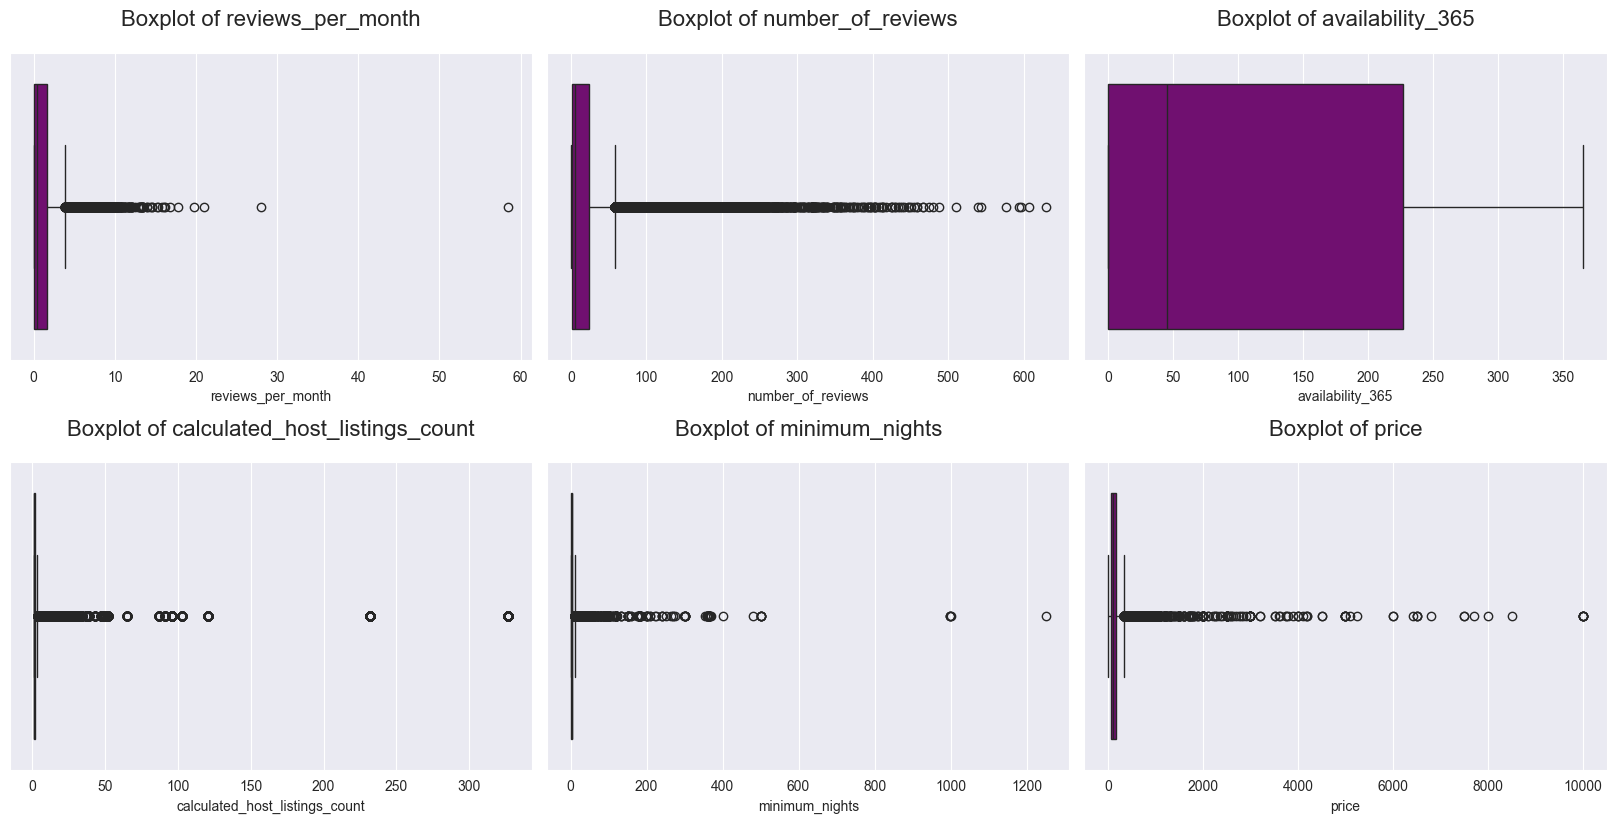

In [52]:
# Fig - Visualizing the box plots for each numeric columns 

visualize_chart(chart_objs, nrows=(len(filter_column) // 3 + 1), ncols=3)
plt.show()

In [53]:
# Transforming data using (log , sqrt) transformations and separating df and outliers in separate dataframe

df1, outlier_df = best_transformation_with_outliers(df, skewness, handle_outliers=True)

Applying log transformation to reviews_per_month due to high_skew skewness.
Applying log transformation to number_of_reviews due to high_skew skewness.
Applying log transformation to calculated_host_listings_count due to high_skew skewness.
Applying log transformation to minimum_nights due to high_skew skewness.
Applying log transformation to price due to high_skew skewness.
Applying sqrt transformation to availability_365 due to moderate_skew skewness.
Outliers detected for 'reviews_per_month': 141
Outliers detected for 'number_of_reviews': 0
Outliers detected for 'calculated_host_listings_count': 5641
Outliers detected for 'minimum_nights': 747
Outliers detected for 'price': 637
Outliers detected for 'availability_365': 0


In [54]:
outlier_df.shape

(6864, 16)

In [55]:
df1.shape

(42031, 16)

## Analysis

In [181]:
# 1. How are Airbnb listings distributed across different neighborhoods in NYC?

airbnb_listing = df1.groupby(by='neighbourhood_group').size().reset_index(name="number_of_listings")
# airbnb_listing
neighbourhood_count = df1[['neighbourhood']].value_counts(sort=False).rename('count').reset_index()
# neighbourhood_count

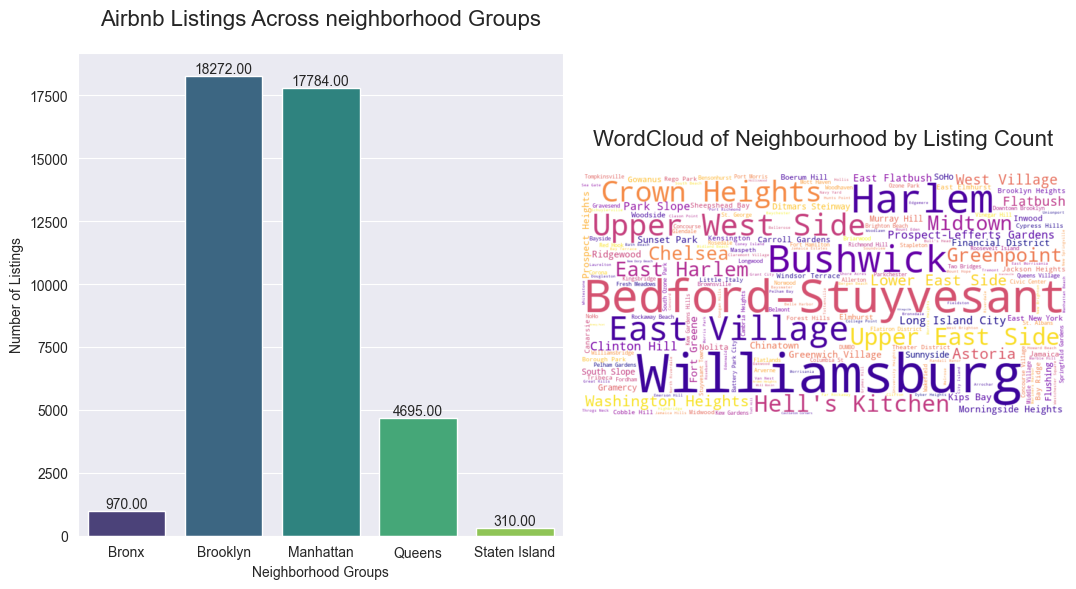

In [153]:
# fig :- distribution of airbnb listings across neighborhoods in NYC

chart_obj = [{
    'xlabel': 'Neighborhood Groups',
    'ylabel': 'Number of Listings',
    'title': 'Airbnb Listings Across neighborhood Groups',
    'plot_function': plot_functions['bar'],
    'x': airbnb_listing['neighbourhood_group'],
    'y': airbnb_listing['number_of_listings'],
    'kwargs': {'hue': airbnb_listing['neighbourhood_group'], 'palette':'viridis'}
}]

# Create a dictionary for neighbourhood_group and their counts
wordcloud_dict = dict(zip(neighbourhood_count['neighbourhood'], neighbourhood_count['count']))

# Generate the word cloud using the frequency of each neighbourhood_group
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate_from_frequencies(wordcloud_dict)

visualize_chart(chart_obj, nrows=1, ncols=2)

# Plot the WordCloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Neighbourhood by Listing Count', fontsize=16, pad=20)


plt.show()

- **Brooklyn and Manhattan** have a competitive data with more than 17,500+ listings across NYC 

- **Brooklyn** leads with the highest number of listings (18,272), marking it as a major hub for short-term rentals.

- **Manhattan** is also prominent with a high count of listings (17,784), reflecting its strong presence in the Airbnb market.

- **Queens** shows a moderate number of listings (4,695), suggesting it's a significant but less concentrated market compared to Manhattan and Brooklyn.

- **Bronx and Staten Island** have relatively few listings (970, and 310 respectively), indicating they are less active in the Airbnb market.

In [182]:
# Room Type Distribution or concentration by Neighbourhood
room_type_distribution = df1[['neighbourhood_group', 'room_type']].value_counts(sort=False).rename('count').reset_index()
# room_type_distribution

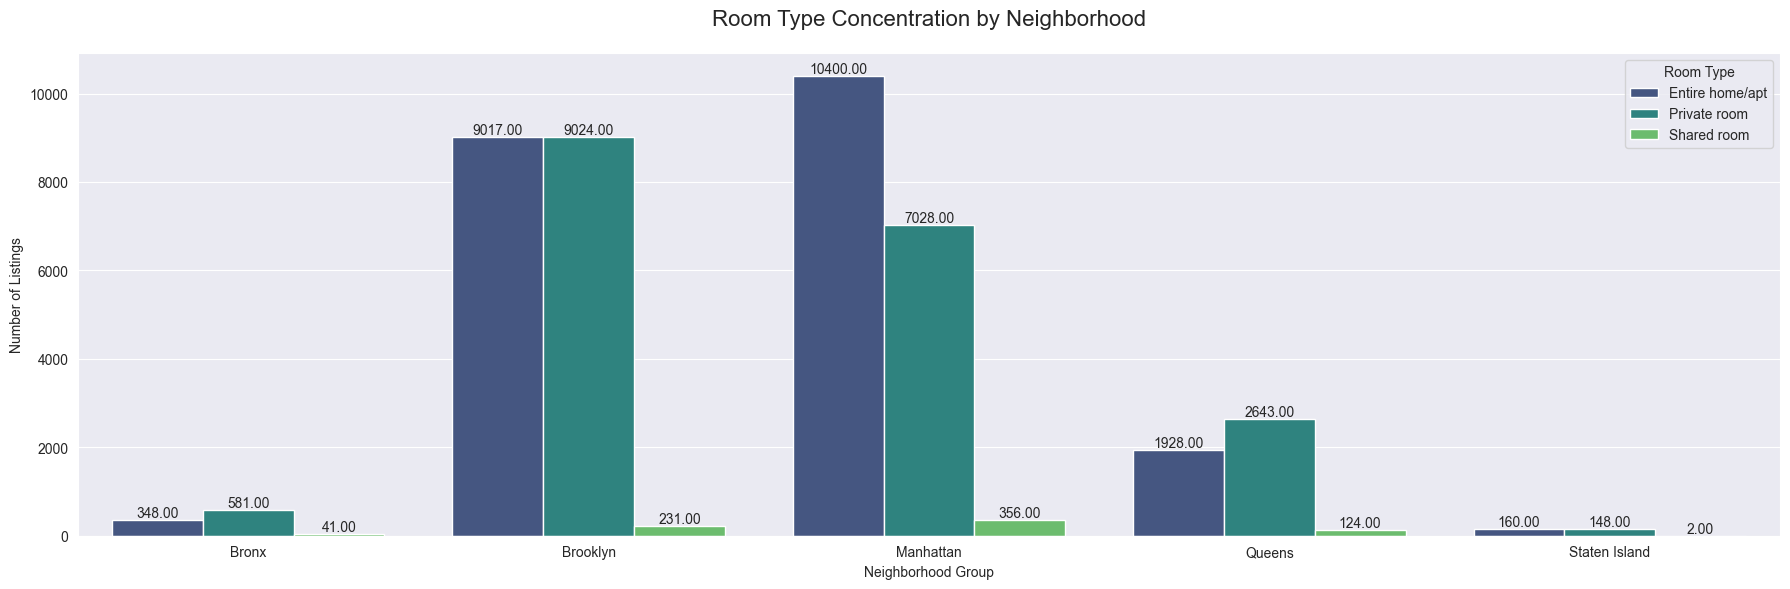

In [59]:
chart_obj = [{

    'plot_function': plot_functions['bar'],
    'x': room_type_distribution['neighbourhood_group'],
    'y': room_type_distribution['count'],
    'title': 'Room Type Concentration by Neighborhood',
    'xlabel': 'Neighborhood Group',
    'ylabel': 'Number of Listings',
    'kwargs': {'hue': room_type_distribution['room_type'], 'palette':'viridis'}
    
}]

visualize_chart(chart_obj, nrows=1, ncols=1)
plt.legend(title='Room Type')
plt.show()

- **Manhattan** has the highest number of entire home/apartment listings (10,400) and private room listings (7,028), reflecting its popularity and demand among travelers.
  
- **Brooklyn** shows a balanced distribution between entire homes/apartments (9,017) and private rooms (9,024), making it a hotspot for both types of accommodations.
  
- **Queens** has a relatively smaller count of listings, with private rooms (2,643) outnumbering entire homes/apartments (1,928).

- **Bronx** has the least number of listings among the main boroughs, with private rooms (581) being the most common.  

- **Staten Island** has the lowest count across all categories, with shared rooms being almost negligible (only 2 listings).  

In [183]:
# What is average price of listings by room type and neighbrouhood_group

avg_price_distribution = df1.groupby(['neighbourhood_group', 'room_type'])['price'].mean().reset_index()
avg_price_distribution['price_org'] = np.expm1(avg_price_distribution['price'])  # Reverse log1p
# avg_price_distribution

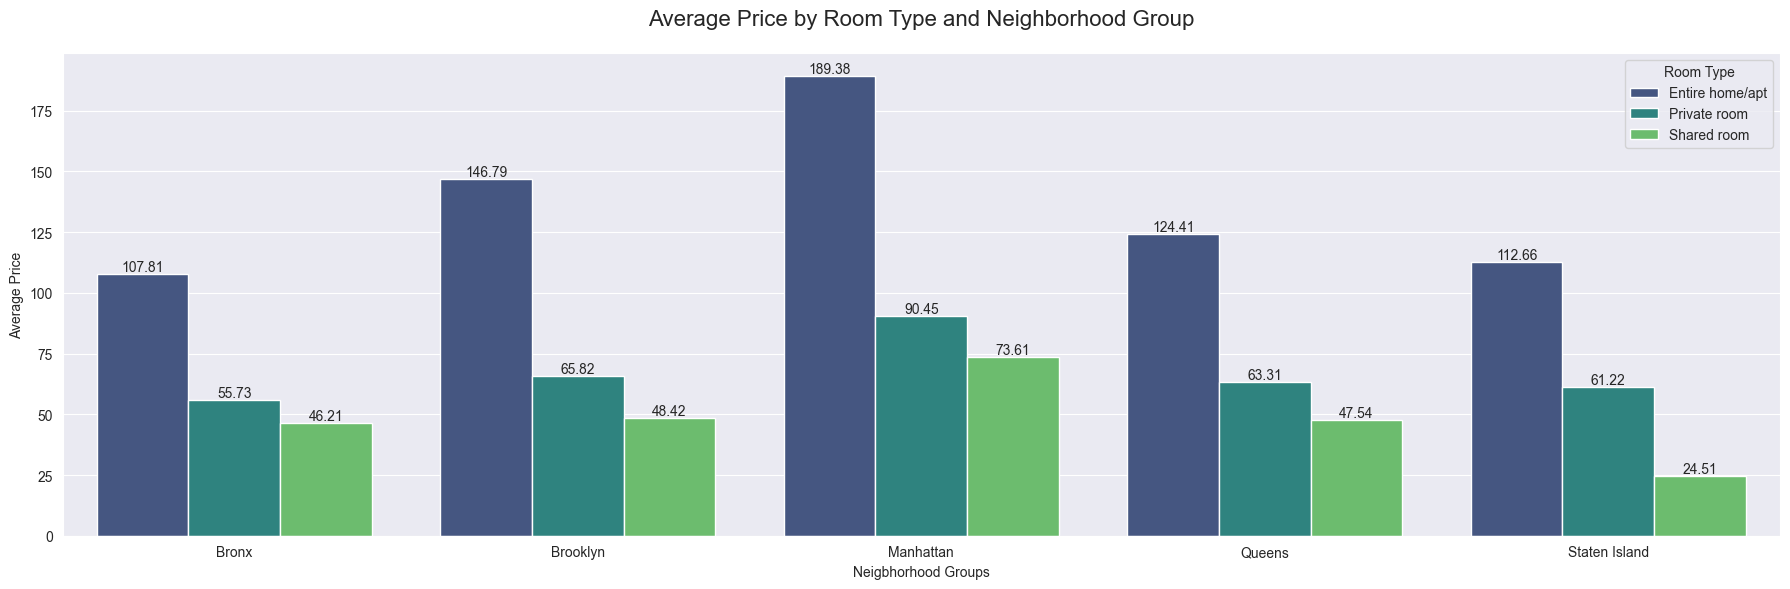

In [61]:
chart_obj = [{
    
    'x': avg_price_distribution['neighbourhood_group'],
    'y': avg_price_distribution['price_org'],
    'plot_function': plot_functions['bar'],
    'title': 'Average Price by Room Type and Neighborhood Group',
    'xlabel': 'Neigbhorhood Groups',
    'ylabel': 'Average Price',
    'kwargs': {'hue': avg_price_distribution['room_type'], 'palette':'viridis'}
}]

visualize_chart(chart_obj, nrows=1, ncols=1)
plt.legend(title='Room Type')
plt.show()

- **Manhattan** has the highest average prices across all room types, with entire homes costing **$189.38**, making it the most expensive borough.

- **Bronx** offers the most affordable listings overall, with shared rooms at **\$46.21** and private rooms at **$55.73**.  

- **Staten Island** is the cheapest for shared rooms at **$24.51**, appealing to budget-conscious travelers.  

- **Entire homes** are consistently the most expensive room type in every borough, followed by private and shared rooms.  

- **Brooklyn** provides a middle-ground option, with entire homes priced at **$146.79**, making it a more affordable alternative to Manhattan.  

In [62]:
# Average price distribution by Room Type

avg_price = df1.groupby(['room_type'])['price'].mean().reset_index()
avg_price['price_org'] = np.expm1(avg_price['price'])  # Reverse log1p
avg_price

,room_type,price,price_org
0,Entire home/apt,5.095027,162.208316
1,Private room,4.304884,73.060645
2,Shared room,4.087617,58.597719


In [63]:
room_type_count = df1[['room_type']].value_counts().rename('count').reset_index()
room_type_count

,room_type,count
0,Entire home/apt,21853
1,Private room,19424
2,Shared room,754


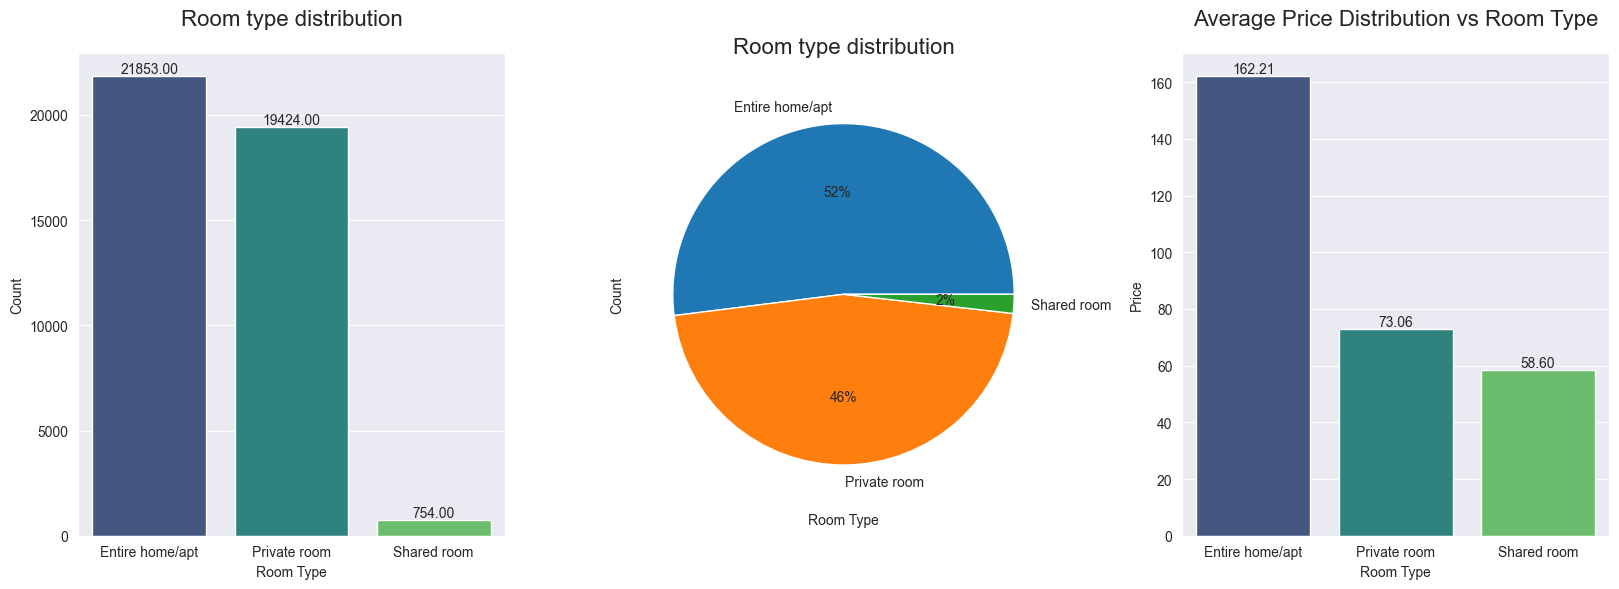

In [64]:
# Fig - Room type and price Distribution

chart_obj = [{
    'plot_function': plot_functions['bar'],
    'x': room_type_count['room_type'],
    'y': room_type_count['count'],
    'xlabel': 'Room Type',
    'ylabel': 'Count',
    'title': 'Room type distribution',
    'kwargs': {'hue': room_type_count['room_type'], 'palette': 'viridis'}
}, {
    'plot_function': plot_functions['pie'],
    'x': room_type_count['count'],
    'xlabel': 'Room Type',
    'ylabel': 'Count',
    'title': 'Room type distribution',
    'kwargs': {'labels': room_type_count['room_type'], 'autopct':'%.f%%'}
}, {
    'plot_function': plot_functions['bar'],
    'x': avg_price['room_type'],
    'y': avg_price['price_org'],
    'xlabel': 'Room Type',
    'ylabel': 'Price',
    'title': 'Average Price Distribution vs Room Type',
    'kwargs': {'hue': avg_price['room_type'], 'palette': 'viridis'}
}]

visualize_chart(chart_obj, nrows=1, ncols=3)
plt.show()

- Entire homes/apartments make up the majority of listings with 52% share, reflecting their popularity among travelers.

- Private rooms account for 46% of listings, providing a budget-friendly option for many users.  

- Shared rooms are a niche category, with only 2% of the total listings, catering to ultra-budget travelers.  

- Average prices vary significantly: entire homes/apartments at **\$162.21**, private rooms at **\$73.06**, and shared rooms at **$58.60**.  

In [185]:
# Average number of reviews per listings by neighbourhood and room type

# Group by neighborhood and room type and calculate the average number of reviews
reviews_per_listing = df1.groupby(['neighbourhood_group', 'room_type'])['number_of_reviews'].mean().reset_index()

reviews_per_listing['reviews_count'] = np.expm1(reviews_per_listing['number_of_reviews'])  # Reverse log1p
# Sort the results for better visualization
reviews_per_listing = reviews_per_listing.sort_values(by='reviews_count', ascending=False)
# reviews_per_listing

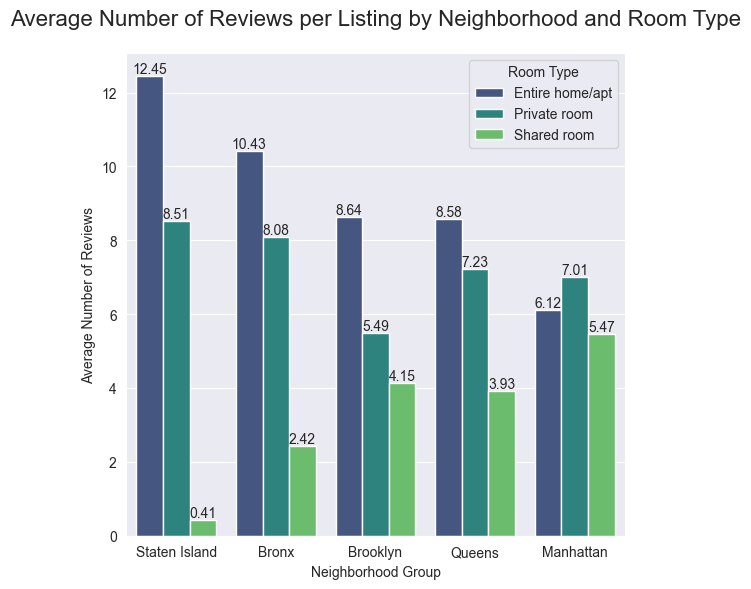

In [110]:
chart_obj = [{

    'plot_function': plot_functions['bar'],
    'x': reviews_per_listing['neighbourhood_group'],
    'y': reviews_per_listing['reviews_count'],
    'title': 'Average Number of Reviews per Listing by Neighborhood and Room Type',
    'xlabel': 'Neighborhood Group',
    'ylabel': 'Average Number of Reviews',
    'kwargs': {'hue': reviews_per_listing['room_type'], 'palette': 'viridis'}

}]

visualize_chart(chart_obj, nrows=1, ncols=2)

plt.legend(title='Room Type')
# Display the plot
plt.show()

- **Staten Island** has the highest average number of reviews for both entire home/apartment listings (12.45) and private room listings (8.51), indicating a highly engaged user base despite having fewer listings overall.

- **Bronx** entire home/apartment listings have the second-highest review count (10.43), suggesting good engagement relative to its smaller listing volume.  

- **Manhattan** has the lowest average review counts across all room types, with shared rooms receiving only 5.47 reviews on average, reflecting lower guest engagement compared to other boroughs.  

- **Shared rooms** consistently receive fewer reviews across all boroughs, with **Staten Island shared rooms** receiving the lowest reviews (0.41), indicating limited popularity or usage.  

- **Brooklyn** shows moderate engagement, with private rooms and shared rooms receiving fewer reviews compared to entire home/apartment listings.

In [137]:
# Average Reviews per host across neighbourhoods

# Group by neighborhood group and host, and calculate the mean review frequency for each host
host_reviews = df1.groupby(['neighbourhood_group', 'host_id'])['reviews_per_month'].mean().reset_index(name='avg_reviews_per_host')    

# Group by neighborhood to calculate the average of all hosts in each group
neighborhood_avg_reviews = host_reviews.groupby('neighbourhood_group')['avg_reviews_per_host'].mean().reset_index()

# Add reverse log1p if data was transformed
neighborhood_avg_reviews['avg_reviews_original_scale'] = np.expm1(neighborhood_avg_reviews['avg_reviews_per_host'])

neighborhood_avg_reviews

,neighbourhood_group,avg_reviews_per_host,avg_reviews_original_scale
0,Bronx,0.695769,1.005251
1,Brooklyn,0.500815,0.650065
2,Manhattan,0.500956,0.650298
3,Queens,0.630206,0.877997
4,Staten Island,0.780769,1.183151


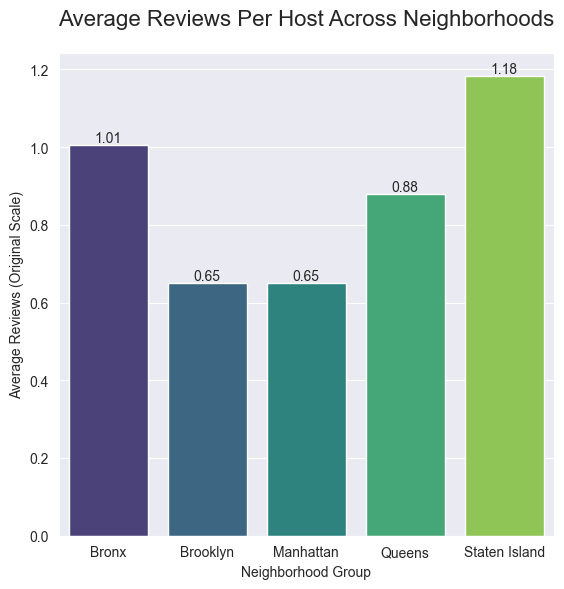

In [136]:

chart_obj = [{
    'plot_function': plot_functions['bar'],
    'title': 'Average Reviews Per Host Across Neighborhoods',
    'xlabel': 'Neighborhood Group',
    'ylabel': 'Average Reviews (Original Scale)',
    'x': neighborhood_avg_reviews['neighbourhood_group'],
    'y': neighborhood_avg_reviews['avg_reviews_original_scale'],
    'kwargs': {'errorbar': None, 'hue':  neighborhood_avg_reviews['neighbourhood_group'], 'palette': 'viridis'}
    
}]

visualize_chart(chart_obj, nrows=1, ncols=2)
plt.show()



- **Staten Island** has the highest average reviews per host (~1.18), suggesting higher engagement or repeat bookings compared to other neighborhoods.
  
- **Bronx** comes next with an average review of ~1.01, indicating relatively active hosts in terms of reviews.

- **Brooklyn** and **Manhattan** show identical lower average reviews (~0.65), suggesting a similar pattern of host activity in these areas.

- **Queens** falls between Staten Island and the rest, with an average review of ~0.88, reflecting moderate activity.

- This pattern could imply that hosts in Staten Island and Bronx have smaller but more engaged customer bases compared to the other boroughs.

In [148]:
# Top 10 host with max listing count

# Group by 'host_id' and count listings
top_hosts_listings = df1.groupby(['host_id', 'host_name'])['id'].count().reset_index(name='listing_count')
# Sort by listing_count in descending order
top_hosts_listings = top_hosts_listings.sort_values(by='listing_count', ascending=False).head(10)
top_hosts_listings

,host_id,host_name,listing_count
34494,245710234,Marcelo Y Lucio,4
35345,264478123,The Broome Hotel,4
10108,8637211,Judie And Steven,4
29615,131354448,Tammie,4
23856,52997121,Iwona,4
17122,24140532,Josh,4
5196,3158364,Devika,4
29592,130971031,J-,4
13694,15640230,Susana,4
2646,1360198,Marina,4



- **Marcelo Y Lucio**, **The Broome Hotel**, and **Judie And Steven** stand out with diverse properties under their management.

- Individual hosts like **Tammie**, **Iwona**, and **Josh** have successfully managed multiple listings, showcasing their hosting capabilities.

- **Devika**, **J-**, and **Susana** also maintain 4 listings each, highlighting their consistency in managing a portfolio of properties.

- Businesses like **The Broome Hotel** suggest that professional hosting setups compete with individual hosts effectively.

In [149]:
# Number of hosts for each unique listing count

# Group by host_id to count the number of listings per host
host_listing_counts = df1.groupby('host_id').size().reset_index(name='listing_count')

# Count the number of hosts for each unique listing count
unique_listing_counts = host_listing_counts['listing_count'].value_counts().reset_index()
unique_listing_counts.columns = ['listing_count', 'host_count']

# Sort the results by listing_count
unique_listing_counts = unique_listing_counts.sort_values(by='listing_count')
unique_listing_counts


,listing_count,host_count
0,1,31469
1,2,3232
2,3,926
3,4,330


In [141]:
# Top 10 hosts with max total_reviews

# Group by 'host_id' and sum reviews
top_hosts_reviews = df1.groupby(['host_id', 'host_name'])['number_of_reviews'].sum().reset_index(name='total_reviews')
# Sort by total_reviews in descending order
top_hosts_reviews = top_hosts_reviews.sort_values(by='total_reviews', ascending=False).head(10)
top_hosts_reviews

         host_id         host_name  total_reviews
22615   47351539             Jason      21.579433
22130   44924546             Hayes      21.383411
653       209460           Marylyn      21.113379
27812   99392252           Michael      20.855609
24923   62843071   Kevin And Kitty      20.027231
28719  114477998           Marilyn      19.878528
5411     3339701            Angelo      19.866998
24663   60346942  Josh & Madeleine      19.804686
5804     3684360           Enrique      19.551090
22744   47993495              Mama      19.500085



- **Jason** leads with the highest total reviews (21.58), showing significant popularity among guests.

- Hosts like **Hayes** and **Marylyn** closely follow, indicating consistently high engagement from their guests.

- **Michael**, **Kevin and Kitty**, and **Marilyn** are among the other top performers, with total reviews ranging from 20.03 to 19.88.

- Joint hosting teams like **Josh & Madeleine** and **Kevin and Kitty** seem to perform well, likely due to shared hosting responsibilities.

- A mix of individual hosts and teams is evident, showcasing that both hosting styles can succeed with high review volumes.


In [186]:
# Sort listings by the number of reviews in descending order
top_reviewed_listings = df1[['id', 'name', 'host_id', 'host_name', 'number_of_reviews']].sort_values(by='number_of_reviews', ascending=False).head(10)

# Display the top 10 listings
top_reviewed_listings


,id,name,host_id,host_name,number_of_reviews
2031,903972,Great Bedroom in Manhattan,4734398,Jj,6.410175
2030,903947,Beautiful Bedroom in Manhattan,4734398,Jj,6.393591
2015,891117,Private Bedroom in Manhattan,4734398,Jj,6.388561
1879,834190,Manhattan Lux Loft.Like.Love.Lots.Look !,2369681,Carol,6.293419
4870,3474320,Private brownstone studio Brooklyn,12949460,Asa,6.192362
471,166172,LG Private Room/Family Friendly,792159,Wanda,6.175867
1271,546383,My Little Guest Room in Flushing,2680820,Linda,6.163315
113,26785,Park Slope Green Guest House,42273,Dani,6.148468
225,58059,PRIVATE Room on Historic Sugar Hill,277379,Agnes,6.129050
1103,467634,yahmanscrashpads,2321321,Lloyd,6.120297



- **Jj** is a standout host with three highly reviewed listings in Manhattan, all exceeding 6,300 reviews.

- Manhattan dominates the list with six out of the top 10 most reviewed listings, showcasing its popularity among guests.

- Brooklyn also features prominently, with two listings, indicating its strong presence as a desirable location.

- The hosts with the highest number of reviews often focus on private rooms or unique accommodations (e.g., "Manhattan Lux Loft").

- Hosts like **Carol**, **Asa**, and **Dani** have single standout listings with exceptionally high review counts, showing their appeal to guests.

## Observing Outliers

In [154]:
result = analyze_dataset(outlier_df, exclude_columns) 

In [155]:
print(summary_factory.generate_summary("overview", result))
print("\n" + "="*80 + "\n")
print(summary_factory.generate_summary("observations", result))

The dataset contains 6864 rows and 16 columns.

There are 2172 missing values across 1 columns.
Missing values account for 1.98% of the dataset.
Columns with missing values and their counts:
  - last_review: 2172 missing values

There are no duplicate rows in the dataset.

Data Types:

                        Column       DataType
                            id          int64
                          name         object
                       host_id          int64
                     host_name         object
           neighbourhood_group         object
                 neighbourhood         object
                      latitude        float64
                     longitude        float64
                     room_type         object
                         price        float64
                minimum_nights        float64
             number_of_reviews        float64
                   last_review datetime64[ns]
             reviews_per_month        float64
calculated_host_listing

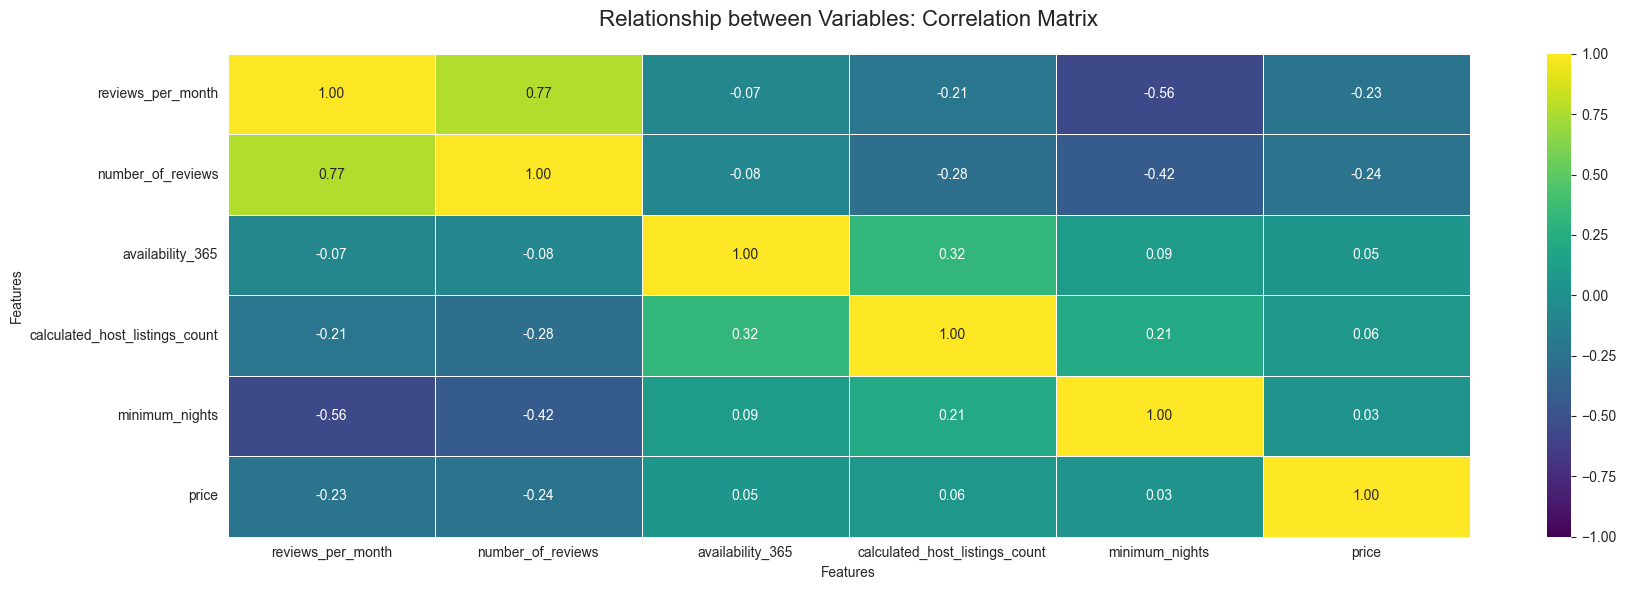

In [156]:
result = analyze_correlation_matrix(outlier_df, filter_column)

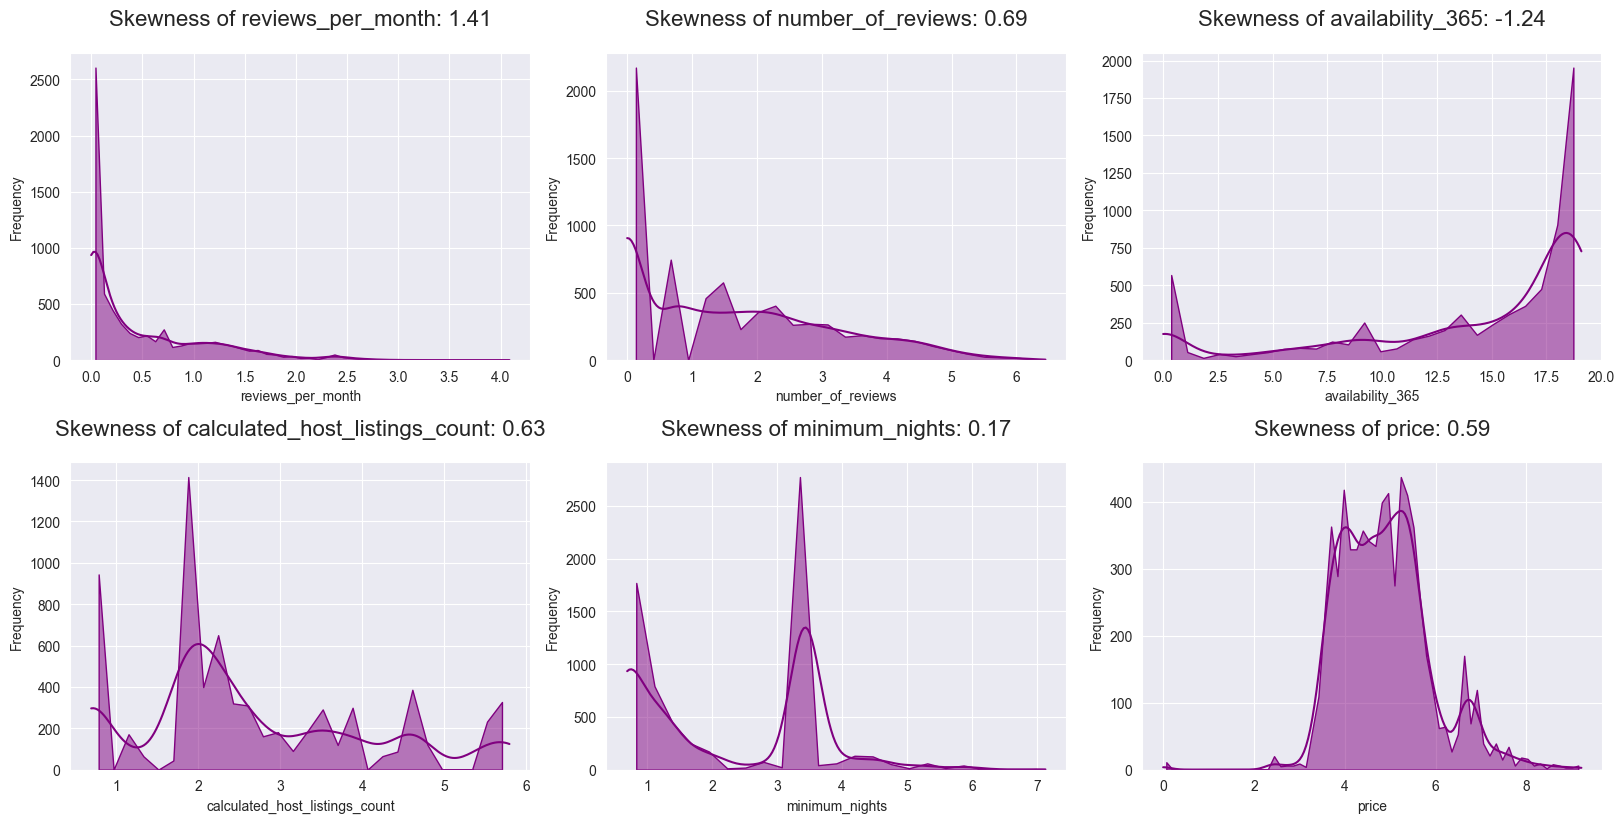

In [157]:
skewness = analyze_skewness(outlier_df, filter_column)

In [158]:
chart_objs = []
for col in filter_column:
    # print(col, skewness[col])
    chart_objs.append({
    'plot_function':plot_functions['box'] ,
    'title': f'Boxplot of {col}',  # Title for each individual column
    'xlabel': col,
    'ylabel': None,
    'x': outlier_df[col],
    'kwargs': { 'color': 'purple'}
    })

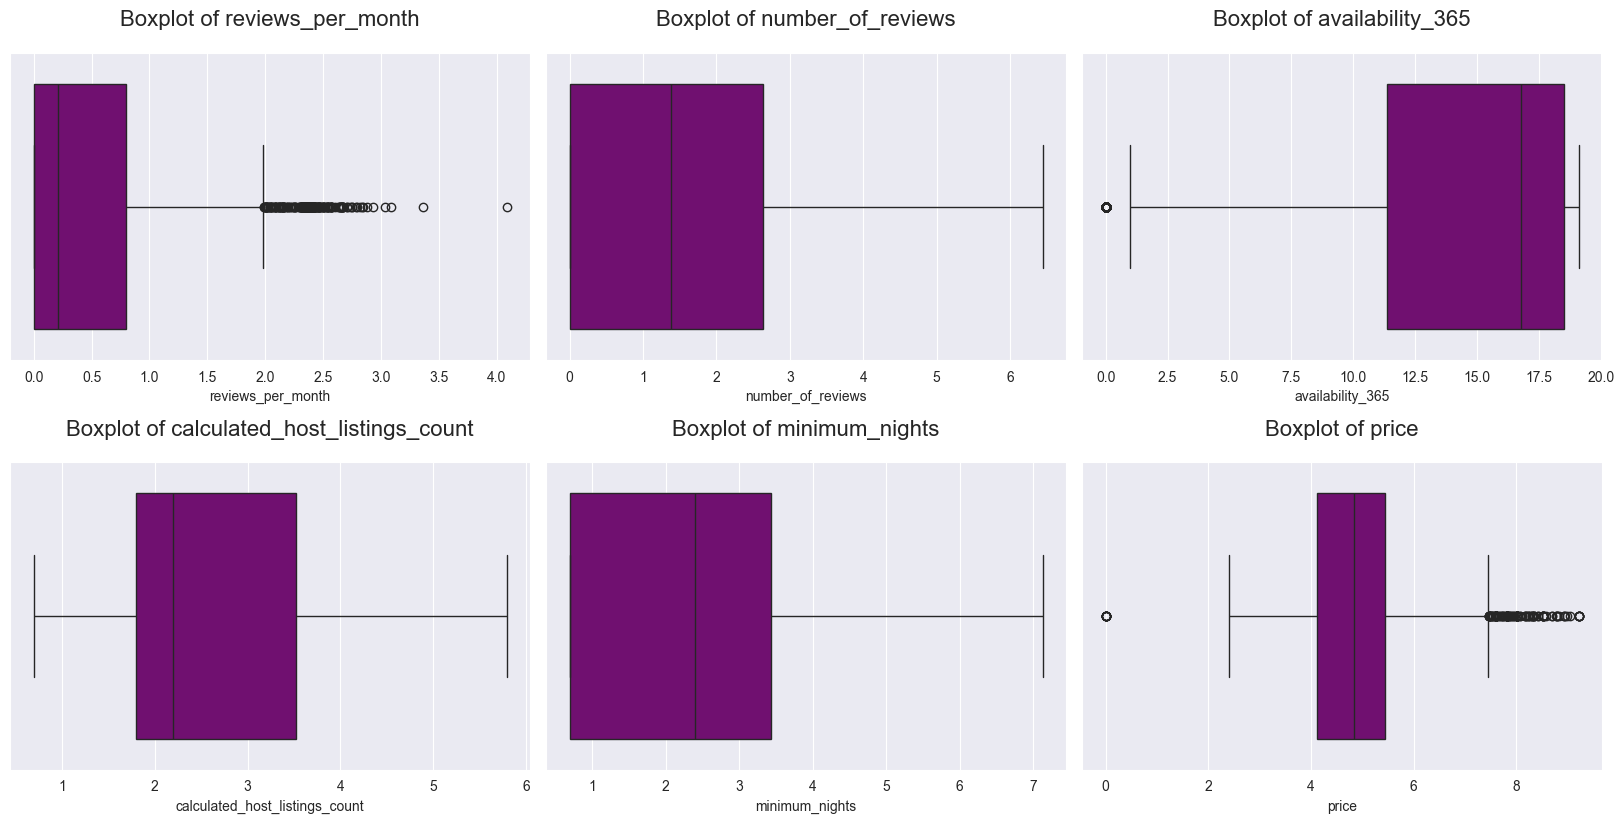

In [159]:
visualize_chart(chart_objs, nrows=(len(filter_column) // 3 + 1), ncols=3)
plt.show()

In [160]:
# 1. How are Airbnb listings distributed across different neighborhoods in NYC?

airbnb_listing = outlier_df.groupby(by='neighbourhood_group').size().reset_index(name="number_of_listings")
# airbnb_listing
neighbourhood_count = outlier_df[['neighbourhood']].value_counts(sort=False).rename('count').reset_index()
# neighbourhood_count

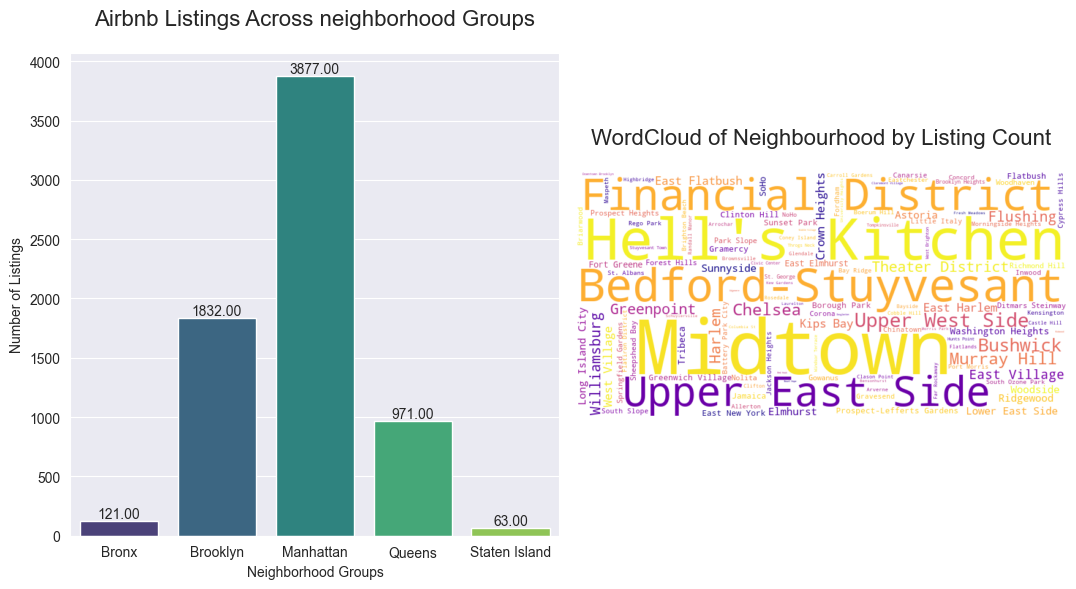

In [161]:
# fig :- distribution of airbnb listings across neighborhoods in NYC

chart_obj = [{
    'xlabel': 'Neighborhood Groups',
    'ylabel': 'Number of Listings',
    'title': 'Airbnb Listings Across neighborhood Groups',
    'plot_function': plot_functions['bar'],
    'x': airbnb_listing['neighbourhood_group'],
    'y': airbnb_listing['number_of_listings'],
    'kwargs': {'hue': airbnb_listing['neighbourhood_group'], 'palette':'viridis'}
}]

# Create a dictionary for neighbourhood_group and their counts
wordcloud_dict = dict(zip(neighbourhood_count['neighbourhood'], neighbourhood_count['count']))

# Generate the word cloud using the frequency of each neighbourhood_group
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate_from_frequencies(wordcloud_dict)

visualize_chart(chart_obj, nrows=1, ncols=2)

# Plot the WordCloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Neighbourhood by Listing Count', fontsize=16, pad=20)


plt.show()

In [162]:
room_type_distribution = outlier_df[['neighbourhood_group', 'room_type']].value_counts(sort=False).rename('count').reset_index()
# room_type_distribution

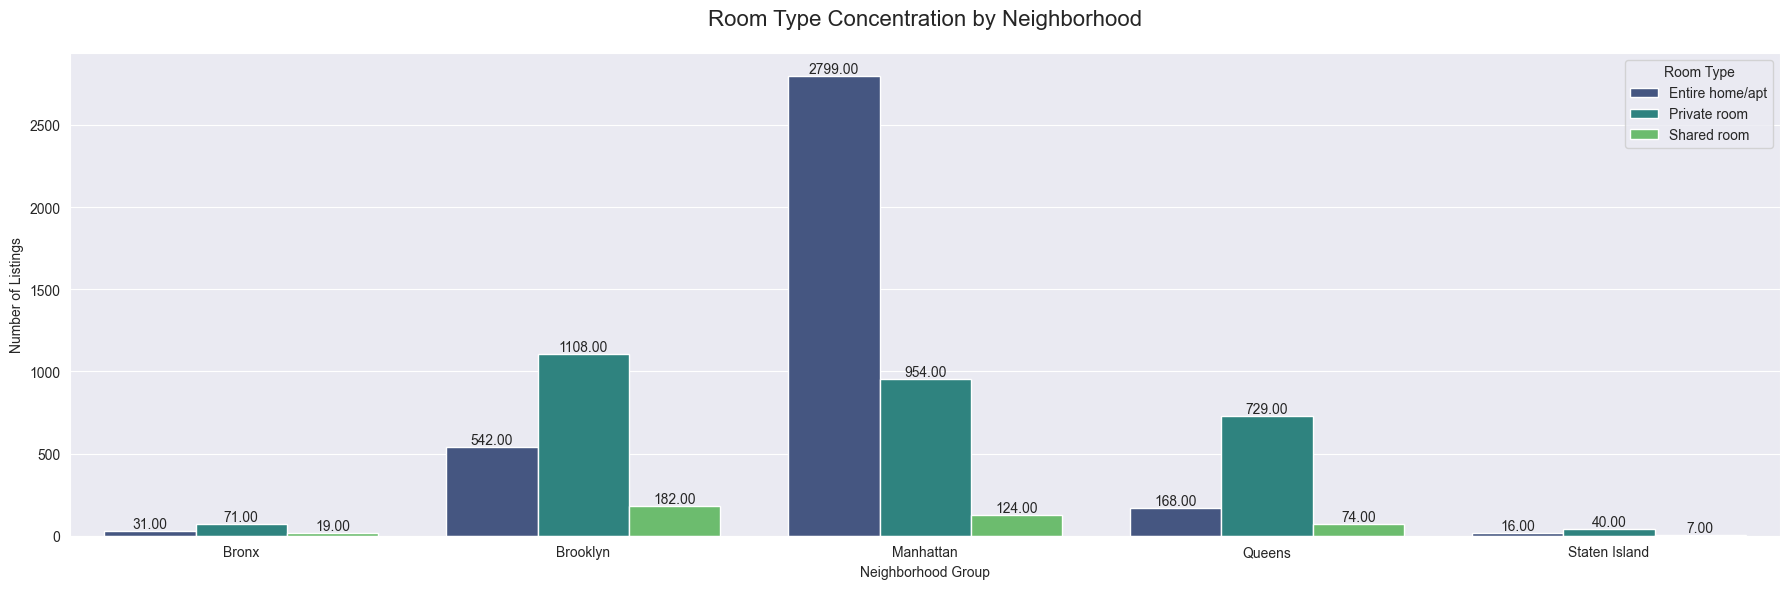

In [163]:
chart_obj = [{

    'plot_function': plot_functions['bar'],
    'x': room_type_distribution['neighbourhood_group'],
    'y': room_type_distribution['count'],
    'title': 'Room Type Concentration by Neighborhood',
    'xlabel': 'Neighborhood Group',
    'ylabel': 'Number of Listings',
    'kwargs': {'hue': room_type_distribution['room_type'], 'palette':'viridis'}
    
}]

visualize_chart(chart_obj, nrows=1, ncols=1)
plt.legend(title='Room Type')
plt.show()

In [164]:
# What is average price of listings by room type and neighbrouhood_group

avg_price_distribution = outlier_df.groupby(['neighbourhood_group', 'room_type'])['price'].mean().reset_index()
avg_price_distribution['price_org'] = np.expm1(avg_price_distribution['price'])  # Reverse log1p
# avg_price_distribution

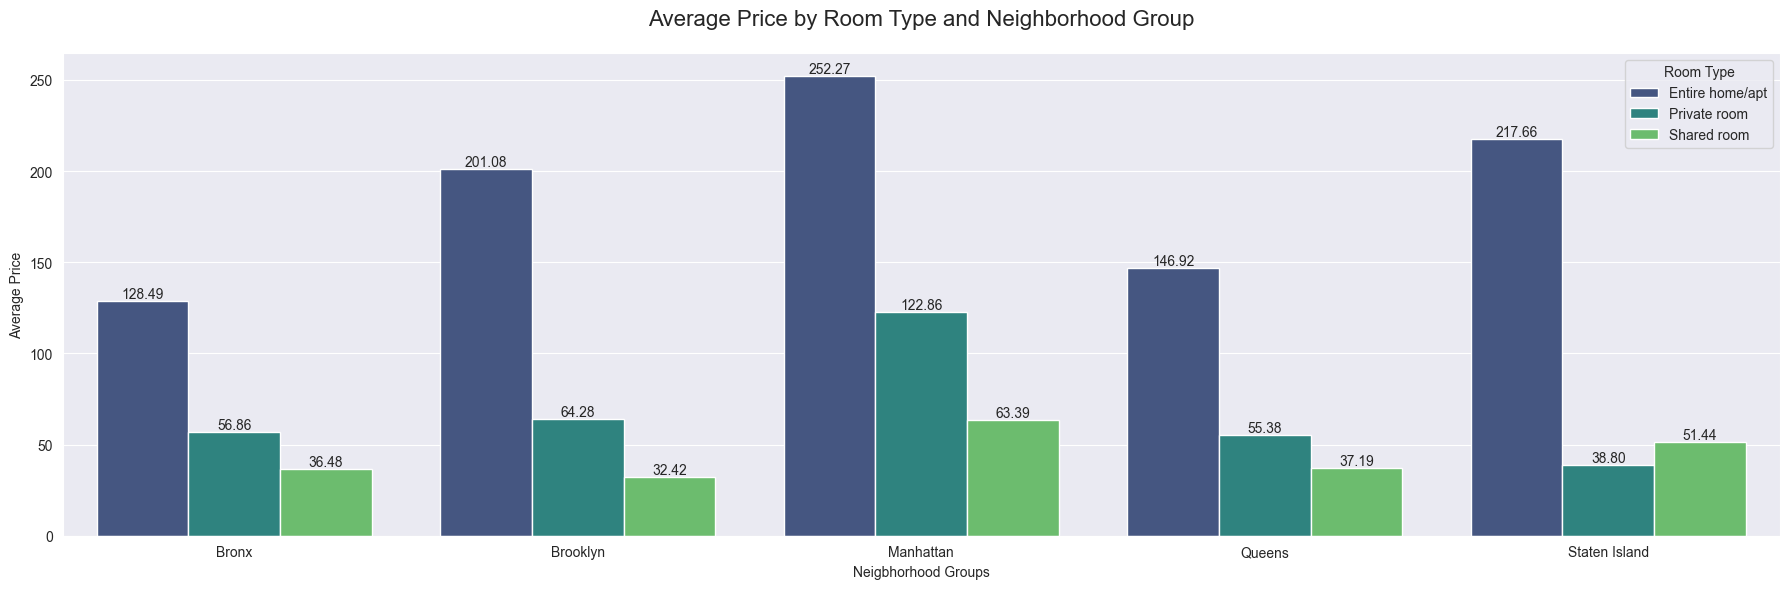

In [165]:
chart_obj = [{
    
    'x': avg_price_distribution['neighbourhood_group'],
    'y': avg_price_distribution['price_org'],
    'plot_function': plot_functions['bar'],
    'title': 'Average Price by Room Type and Neighborhood Group',
    'xlabel': 'Neigbhorhood Groups',
    'ylabel': 'Average Price',
    'kwargs': {'hue': avg_price_distribution['room_type'], 'palette':'viridis'}
}]

visualize_chart(chart_obj, nrows=1, ncols=1)
plt.legend(title='Room Type')
plt.show()

In [166]:
# Average price distribution 

avg_price = outlier_df.groupby(['room_type'])['price'].mean().reset_index()
avg_price['price_org'] = np.expm1(avg_price['price'])  # Reverse log1p
avg_price

,room_type,price,price_org
0,Entire home/apt,5.468128,236.016077
1,Private room,4.342627,75.909284
2,Shared room,3.746904,41.389628


In [167]:
room_type_count = outlier_df[['room_type']].value_counts().rename('count').reset_index()
room_type_count

,room_type,count
0,Entire home/apt,3556
1,Private room,2902
2,Shared room,406


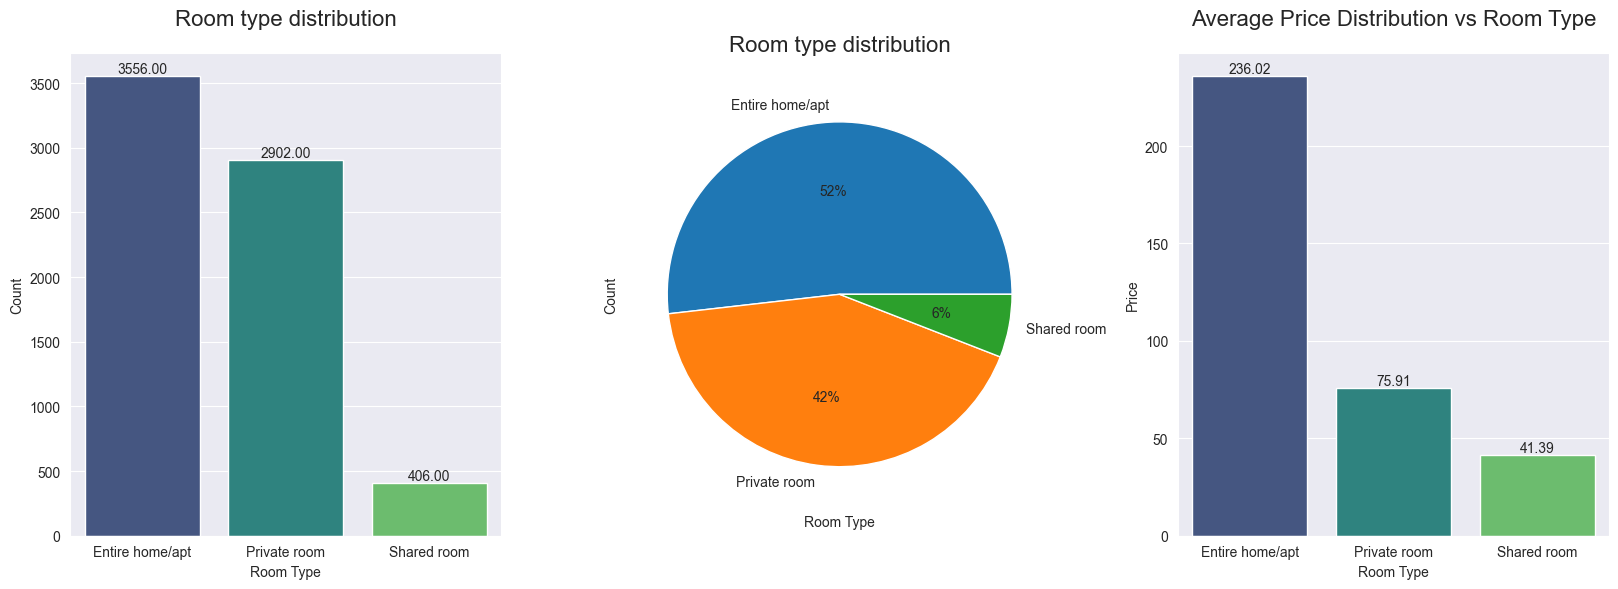

In [168]:
# Fig - Room type and price Distribution

chart_obj = [{
    'plot_function': plot_functions['bar'],
    'x': room_type_count['room_type'],
    'y': room_type_count['count'],
    'xlabel': 'Room Type',
    'ylabel': 'Count',
    'title': 'Room type distribution',
    'kwargs': {'hue': room_type_count['room_type'], 'palette': 'viridis'}
}, {
    'plot_function': plot_functions['pie'],
    'x': room_type_count['count'],
    'xlabel': 'Room Type',
    'ylabel': 'Count',
    'title': 'Room type distribution',
    'kwargs': {'labels': room_type_count['room_type'], 'autopct':'%.f%%'}
}, {
    'plot_function': plot_functions['bar'],
    'x': avg_price['room_type'],
    'y': avg_price['price_org'],
    'xlabel': 'Room Type',
    'ylabel': 'Price',
    'title': 'Average Price Distribution vs Room Type',
    'kwargs': {'hue': avg_price['room_type'], 'palette': 'viridis'}
}]

visualize_chart(chart_obj, nrows=1, ncols=3)
plt.show()

In [169]:
# Group by neighborhood and room type and calculate the average number of reviews
reviews_per_listing = outlier_df.groupby(['neighbourhood_group', 'room_type'])['number_of_reviews'].mean().reset_index()

reviews_per_listing['reviews_count'] = np.expm1(reviews_per_listing['number_of_reviews'])  # Reverse log1p
# Sort the results for better visualization
reviews_per_listing = reviews_per_listing.sort_values(by='reviews_count', ascending=False)
# reviews_per_listing

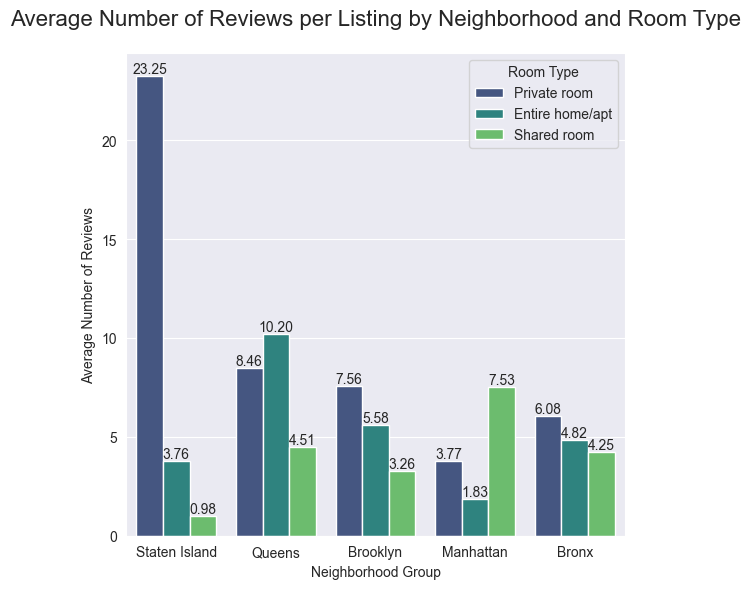

In [170]:
chart_obj = [{

    'plot_function': plot_functions['bar'],
    'x': reviews_per_listing['neighbourhood_group'],
    'y': reviews_per_listing['reviews_count'],
    'title': 'Average Number of Reviews per Listing by Neighborhood and Room Type',
    'xlabel': 'Neighborhood Group',
    'ylabel': 'Average Number of Reviews',
    'kwargs': {'hue': reviews_per_listing['room_type'], 'palette': 'viridis'}

}]

visualize_chart(chart_obj, nrows=1, ncols=2)

plt.legend(title='Room Type')
# Display the plot
plt.show()

In [171]:
# # Assuming you have a 'rating' column (or 'reviews_per_month' as a proxy)

# Group by neighborhood group and host, and calculate the mean review frequency for each host
host_reviews = outlier_df.groupby(['neighbourhood_group', 'host_id'])['reviews_per_month'].mean().reset_index(name='avg_reviews_per_host')    

# Group by neighborhood to calculate the average of all hosts in each group
neighborhood_avg_reviews = host_reviews.groupby('neighbourhood_group')['avg_reviews_per_host'].mean().reset_index()

# Add reverse log1p if data was transformed
neighborhood_avg_reviews['avg_reviews_original_scale'] = np.expm1(neighborhood_avg_reviews['avg_reviews_per_host'])

neighborhood_avg_reviews

,neighbourhood_group,avg_reviews_per_host,avg_reviews_original_scale
0,Bronx,0.545464,0.725408
1,Brooklyn,0.477951,0.612766
2,Manhattan,0.378160,0.459597
3,Queens,1.064844,1.900385
4,Staten Island,0.763839,1.146501


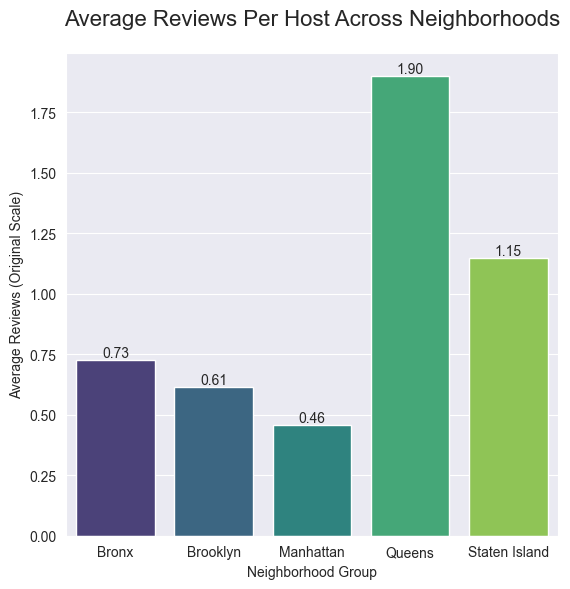

In [172]:

chart_obj = [{
    'plot_function': plot_functions['bar'],
    'title': 'Average Reviews Per Host Across Neighborhoods',
    'xlabel': 'Neighborhood Group',
    'ylabel': 'Average Reviews (Original Scale)',
    'x': neighborhood_avg_reviews['neighbourhood_group'],
    'y': neighborhood_avg_reviews['avg_reviews_original_scale'],
    'kwargs': {'errorbar': None, 'hue':  neighborhood_avg_reviews['neighbourhood_group'], 'palette': 'viridis'}
    
}]

visualize_chart(chart_obj, nrows=1, ncols=2)
plt.show()


In [173]:
# Group by 'host_id' and count listings
top_hosts_listings = outlier_df.groupby(['host_id', 'host_name'])['id'].count().reset_index(name='listing_count')
# Sort by listing_count in descending order
top_hosts_listings = top_hosts_listings.sort_values(by='listing_count', ascending=False).head(10)
top_hosts_listings

,host_id,host_name,listing_count
1448,219517861,Sonder (NYC),327
1156,107434423,Blueground,232
777,30283594,Kara,121
1242,137358866,Kazuya,103
592,16098958,Jeremy & Laura,96
548,12243051,Sonder,96
1002,61391963,Corporate Housing,91
689,22541573,Ken,87
1388,200380610,Pranjal,65
161,1475015,Mike,52


In [174]:
# Group by host_id to count the number of listings per host
host_listing_counts = outlier_df.groupby('host_id').size().reset_index(name='listing_count')

# Count the number of hosts for each unique listing count
unique_listing_counts = host_listing_counts['listing_count'].value_counts().reset_index()
unique_listing_counts.columns = ['listing_count', 'host_count']

# Sort the results by listing_count
unique_listing_counts = unique_listing_counts.sort_values(by='listing_count')
unique_listing_counts


,listing_count,host_count
0,1,1102
5,2,46
11,3,7
24,4,2
1,5,169
2,6,95
3,7,57
4,8,52
6,9,26
7,10,21


In [175]:
# Group by 'host_id' and sum reviews
top_hosts_reviews = outlier_df.groupby(['host_id', 'host_name'])['number_of_reviews'].sum().reset_index(name='total_reviews')
# Sort by total_reviews in descending order
top_hosts_reviews = top_hosts_reviews.sort_values(by='total_reviews', ascending=False).head(10)
top_hosts_reviews

,host_id,host_name,total_reviews
1448,219517861,Sonder (NYC),374.778754
1002,61391963,Corporate Housing,135.396673
1189,119669058,Melissa,91.668648
65,417504,The Box House Hotel,87.643247
1367,190921808,John,83.873210
207,2119276,Host,83.160857
416,7503643,Vida,81.678972
726,25237492,Juliana,73.952938
1466,224414117,Gabriel,70.134066
592,16098958,Jeremy & Laura,66.306852


In [176]:
# Sort listings by the number of reviews in descending order
top_reviewed_listings = outlier_df[['id', 'name', 'host_id', 'host_name', 'number_of_reviews']].sort_values(by='number_of_reviews', ascending=False).head(10)

# Display the top 10 listings
top_reviewed_listings


,id,name,host_id,host_name,number_of_reviews
11759,9145202,Room near JFK Queen Bed,47621202,Dona,6.445720
13495,10101135,Room Near JFK Twin Beds,47621202,Dona,6.357842
10623,8168619,Steps away from Laguardia airport,37312959,Maya,6.298949
20403,16276632,Cozy Room Family Home LGA Airport NO CLEANING FEE,26432133,Danielle,6.236370
8001,6157276,Bright LARGE BED near Manhattan,23591164,Angela,6.146329
13612,10186192,Only Steps away from LaGuardia arpt,37312959,Maya,6.131226
9323,7125107,Room steps away from LaGuardia airport,37312959,Maya,6.107023
22469,18173787,Cute Tiny Room Family Home by LGA NO CLEANING FEE,26432133,Danielle,6.079933
19186,15262831,THE PRIVACY DEN ~ 5 MINUTES TO JFK,97086824,Miss Dy,6.075346
7086,5115372,Comfy Room Family Home LGA Airport NO CLEANING...,26432133,Danielle,6.066108
